# Analysis of renter-occupied households in the American Housing Survey (as modified by the "Data Preparation" Notebook). 

The American Housing Survey (AHS) is being utilized to address the following:
- Increasing the supply of housing at all income levels is one of the leading strategies to solving the housing affordability crisis based on the economic principle that increased supply will reduce demand and alleviate price pressures on housing markets. **What can we observe from the AHS on changes among renter-occupied housing units, changes in rent for different income groups, and the characteristics of the rental housing units in Metropolitan Areas that have contributed more to their overall housing stock?**

It is important to note that there are multiple issues at play when discussing new housing supply and its ability to meet the needs of very-low or extremely-low income households that should not be conflated:
- How much can we expect new housing supply to moderate pressures on rent, especially for low-income households? Does new housing supply lower rents or allow lower-income families to find greater affordability through “filtering” and "moving chains." The evidence is generally "yes", though there needs to be more research on how this varies by geographic context.
    - This analysis of the American Housing Survey (AHS) will help validate this by looking at select metropolitan areas.
        - "Supply" Cohort
            - Atlanta-Sandy Springs-Roswell, GA (12060)
            - Dallas-Fort Worth-Arlington, TX (19100)
            - Houston-The Woodlands-Sugar Land, TX (26420)
            - Miami-Fort Lauderdale-West Palm Beach, FL (33100)
            - Phoenix-Mesa-Scottsdale, AZ (38060)
            - Seattle-Tacoma-Bellevue, WA (42660)
            - Washington-Arlington-Alexandria, DC-VA-MD (47900)
    - The following metropolitan areas will be used for comparisons
        - "Constraint" Cohort
            - Boston-Cambridge-Quincy, MA-NH (14460)
            - Los Angeles-Long Beach-Anaheim, CA (31080)
            - New York-Newark-Jersey City, NY-NJ-PA (35620)
            - Riverside-San Bernardino-Ontario, CA (40140)
            - San Francisco-Oakland-Hayward, CA (41860)
        - "Other" Cohort
            - Chicago-Naperville-Elgin, IL-IN-WI (16980)
            - Detroit-Warren-Dearborn, MI (19820)
            - Philadelphia-Camden-Wilmington, PA-NJ-DE-MD (37980)
        
- How do we expand the supply of subsidized affordable units? Through HUD vouchers? Through LIHTC? Or a different model? This is not a function of "new supply" or rezoning policies, it is a function of subsidy design and implementation, as well as streamlining these subsidy sources. How do we structure subsidies most effectively to ensure that very low and extremely low income households also have access to affordable housing?
    - This analysis of AHS data _**will not**_ address this question. 

#### Using the longitudual data of the American Housing Survey. I will analyze the following:
Identify cohorts of rental units that were occupied by a lower-income household and observe any changes throughout the panel data.

**NOTE**: HUD staff suggest using 2015 as "base weights" to apply to any longitudinal analysis.

**Research Questions:**
1. How has the (weighted) share of rental housing units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?
    - Visualize by weighted count as well
2. To what extent does a housing unit stay occupied by an income group over time?
 
3. Changes in rent for renter-occupied households of market-rate units (i.e., unsubsidized, not income-restricted housing)
    - How have rents changed for units occupied by lower-income households (<= 80% AMI) in relation to units occupied by higher-income households (>80 AMI)? 
    - What is the percent change of rent for renter occupied units in each income group over time (2015-2023)?
    - Are rent increases higher for ELI, LI, or LI renter-occupied units than for units occupied by higher-income renters?
4. What does the new rental stock look like for different income groups?

5. Are vacancy rates higher for different unit types (size, age)? What are the rents for vancant units that are for rent? 

In [1]:
#Importing Libraries
import requests
from io import StringIO

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
#Loading 2023 AHS METRO PUF w/ selected columns
metro_ami_panel_df = pd.read_csv('data/ahs/metro_ami_panel_df.csv')
metro_ami_panel_df

,CONTROL,RENT,TENURE,RENTCNTRL,RENTSUB,OMB13CBSA,WEIGHT,BLD,HHMOVE,NUMPEOPLE,...,l80_3,l80_4,l80_5,l80_6,l80_7,l80_8,ELI_threshold,VLI_threshold,LI_threshold,AMI
0,11000002,1600,-6,-6,8,99998,813.890194,3,-6,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000003,840,2,-6,8,99998,581.103231,3,2023,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000005,-6,1,-6,-6,99998,7335.965001,2,1995,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000006,-6,1,-6,-6,99998,6562.865941,2,2019,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000008,800,2,-6,8,99998,1490.800600,6,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315474,11085283,-6,1,-6,-6,99998,3859.804765,2,1975,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315475,11085284,-6,1,-6,-6,99998,3144.087005,2,1977,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315476,11085285,-6,1,-6,-6,99998,3651.695106,2,2001,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315477,11085286,-6,1,-6,-6,99998,3628.333016,2,2007,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Inspecting the shape/info of the stacked DataFrame
print(metro_ami_panel_df.shape)
print(metro_ami_panel_df.info())

(315479, 51)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315479 entries, 0 to 315478
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CONTROL         315479 non-null  int64  
 1   RENT            315479 non-null  int64  
 2   TENURE          315479 non-null  int64  
 3   RENTCNTRL       315479 non-null  int64  
 4   RENTSUB         315479 non-null  int64  
 5   OMB13CBSA       315479 non-null  int64  
 6   WEIGHT          315479 non-null  float64
 7   BLD             315479 non-null  int64  
 8   HHMOVE          315479 non-null  int64  
 9   NUMPEOPLE       315479 non-null  int64  
 10  SAMEHHLD        246929 non-null  float64
 11  YRBUILT         315479 non-null  int64  
 12  BEDROOMS        315479 non-null  int64  
 13  VACMONTHS       315479 non-null  int64  
 14  HUDSUB          315479 non-null  int64  
 15  VACANCY         315479 non-null  int64  
 16  HINCP           315479 non-null  int64  
 1

In [4]:
#Creating function to change columns back to their original dtype
def convert_columns_to_string(df, columns):
    """
    Convert specified columns in a DataFrame to string (object) dtype.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify
    columns (list of str): List of column names to convert

    Returns:
    pd.DataFrame: DataFrame with specified columns converted to string
    """
    df = df.copy()  # Avoid modifying original DataFrame
    for col in columns:
        df[col] = df[col].astype(str)
    return df

In [5]:
#Usage:
columns = ['CONTROL', 'TENURE', 'RENTCNTRL', 'RENTSUB', 'OMB13CBSA', 'BLD', 'SAMEHHLD', 'HUDSUB', 'VACANCY']
metro_ami_panel_df = convert_columns_to_string(metro_ami_panel_df, columns)

In [6]:
#re-inspecting DataFrame
print(metro_ami_panel_df.shape)
print(metro_ami_panel_df.info())

(315479, 51)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315479 entries, 0 to 315478
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CONTROL         315479 non-null  object 
 1   RENT            315479 non-null  int64  
 2   TENURE          315479 non-null  object 
 3   RENTCNTRL       315479 non-null  object 
 4   RENTSUB         315479 non-null  object 
 5   OMB13CBSA       315479 non-null  object 
 6   WEIGHT          315479 non-null  float64
 7   BLD             315479 non-null  object 
 8   HHMOVE          315479 non-null  int64  
 9   NUMPEOPLE       315479 non-null  int64  
 10  SAMEHHLD        315479 non-null  object 
 11  YRBUILT         315479 non-null  int64  
 12  BEDROOMS        315479 non-null  int64  
 13  VACMONTHS       315479 non-null  int64  
 14  HUDSUB          315479 non-null  object 
 15  VACANCY         315479 non-null  object 
 16  HINCP           315479 non-null  int64  
 1

## General Helper Functions
I am creating two (2) global helper functions that will be used in each analysis:
- Incorporating the `'WEIGHT'` variable
    - `w_mean` function to calucate the weighted mean of a variable
    - `w_sum` function to calucation the wieghted sum of a variable
    - `weighted_mean_by_group` function to calculate a weighted mean by a group of variables (i.e., Metro Area, Year)
    - `weighted_count_by_group` function to calculate a weighted count by a group of variables (i.e., Metro Area, Year)
- Mapping to Metro Areas by CBSA Code 
    - `create_cbsa_name_mapping()` provide a **hardcoded**, readable mapping of CBSA codes to metro names.
        - Returns a dictionary of `'OMB13CBSA'` variables to readable/user friendly metro names.
        - **Note:** The `metro_rent_ami_df` DataFrame only contains the target metro areas listed above so it is not necessary at this point. However, if future analysis call for national comparisons this function will help isolate analyses to the select metros when needed.

### Weighting: First Approach for Means and Total Counts

The cell below is a set of code where I define two separate "helper" functions.  The first is to calculate a weighted mean, the second is to create a weighted sum. Use the `w_mean` and `w_sum` functions in cells to specify the weighted output.  

In [7]:
#Helper function for weighted mean.
def w_mean(df, val_col, wt_col):
    w = df[wt_col]
    if w.sum() == 0 or w.isna().all():
        return np.nan
    return np.average(df[val_col], weights=w)

#Helper function for weighted sum.
def w_sum(df, val_col, wt_col):
    product = df[val_col] * df[wt_col]
    return product.sum() if not product.empty else np.nan

In [8]:
#Weighted Stats by Group. The functions below provide weighted means or totals **by metro area or year**.

#Weight mean by group
def weighted_mean_by_group(df, group_cols, val_col, wt_col='WEIGHT'):
    return (
        df.groupby(group_cols)
        .apply(lambda g: np.average(g[val_col], weights=g[wt_col]))
        .reset_index(name=f'{val_col}_weighted_mean')
    )

#Weighted sum by group
def weighted_count_by_group(df, group_cols, wt_col='WEIGHT'):
    return (
        df.groupby(group_cols)[wt_col]
        .sum()
        .reset_index(name='weighted_count')
    )

In [9]:
#Preview Function Usage

#Examining the weighted count of households within each AMI group.
weighted_count_by_group(metro_ami_panel_df, ['SRVYEAR', 'OMB13CBSA', 'AMI'])

,SRVYEAR,OMB13CBSA,AMI,weighted_count
0,2015,12060,Above LI,1.158635e+06
1,2015,12060,ELI,2.772603e+05
2,2015,12060,LI,3.160741e+05
3,2015,12060,VLI,2.027169e+05
4,2015,14460,Above LI,1.115774e+06
...,...,...,...,...
295,2023,42660,VLI,1.917032e+05
296,2023,47900,Above LI,1.666546e+06
297,2023,47900,ELI,3.477682e+05
298,2023,47900,LI,1.566157e+05


In [10]:
#Examining the weighted average household income based on AMI classification
weighted_mean_by_group(metro_ami_panel_df, ['AMI','SRVYEAR'], 'NUMPEOPLE')

,AMI,SRVYEAR,NUMPEOPLE_weighted_mean
0,Above LI,2015,2.677171
1,Above LI,2017,2.754923
2,Above LI,2019,2.741543
3,Above LI,2021,2.753219
4,Above LI,2023,2.728010
5,ELI,2015,2.304376
6,ELI,2017,2.190256
7,ELI,2019,2.136411
8,ELI,2021,2.170862
9,ELI,2023,2.053233


### Establishing the CBSA Mapping functions
- **Goal:** Provide a hardcoded, readable mapping of CBSA codes to names.
- **Returns:** dict of `'OMB13CBSA'` → Metro names.

In [11]:
def supply_cbsa_mapping():
    """
    Create a mapping from CBSA codes to readable names.
    
    Return a stable mapping from CBSA codes (OMB13CBSA) to consistent, readable metro names.
    
    Returns:
    Dictionary mapping CBSA codes (as strings) to user-friendly names
    """
    
    #Default mapping for common CBSAs
    return {
        '47900': "Washington-Arlington-Alexandria, DC-VA-MD",
        '19100': "Dallas-Fort Worth-Arlington, TX",
        '26420': "Houston-The Woodlands-Sugar Land, TX",
        '33100': "Miami-Fort Lauderdale-West Palm Beach, FL",
        '38060': "Phoenix-Mesa-Scottsdale, AZ",
        '42660': "Seattle-Tacoma-Bellevue, WA",
        '12060': "Atlanta-Sandy Springs-Roswell, GA"
    }

In [12]:
def constraint_cbsa_mapping():
    """
    Create a mapping from CBSA codes to readable names.
    
    Return a stable mapping from CBSA codes (OMB13CBSA) to consistent, readable metro names.
    
    Returns:
    Dictionary mapping CBSA codes (as strings) to user-friendly names
    """
    
    #Default mapping for common CBSAs
    return {
        '14460': "Boston-Cambridge-Quincy, MA-NH",
        '31080': "Los Angeles-Long Beach-Anaheim, CA",
        '35620': "New York-Newark-Jersey City, NY-NJ-PA",
        '40140': "Riverside-San Bernardino-Ontario, CA",
        '41860': "San Francisco-Oakland-Hayward, CA"
    }

In [13]:
def other_cbsa_mapping():
    """
    Create a mapping from CBSA codes to readable names.
    
    Return a stable mapping from CBSA codes (OMB13CBSA) to consistent, readable metro names.
    
    Returns:
    Dictionary mapping CBSA codes (as strings) to user-friendly names
    """
    
    #Default mapping for common CBSAs
    return {
        '16980': "Chicago-Naperville-Elgin, IL-IN-WI",
        '19820': "Detroit-Warren-Dearborn, MI",
        '37980': "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD"
    }

In [14]:
def combine_all_cbsa_mappings():
    combined = {}
    combined.update(supply_cbsa_mapping())
    combined.update(constraint_cbsa_mapping())
    combined.update(other_cbsa_mapping())
    return combined

#### Quick check on sample size of the same housing units (unique `'CONTROL'` number) that appear in every wave/year of the survey

In [15]:
# #Checking the size of the sample for unique housing units interviewed in every survey year
# controls_in_all_years = (
#     metro_ami_panel_df[['CONTROL', 'SRVYEAR']]
#     .drop_duplicates().
#     groupby('CONTROL')['SRVYEAR'].nunique()
#     .loc[lambda x: x == metro_ami_panel_df['SRVYEAR'].nunique()]
#     .index
# )

In [16]:
# len(controls_in_all_years)

# #Looking at the actual CONTROL values that persist across all years
# #print(controls_in_all_years.tolist())

#### Creating a DataFrame that _only_ consists of renter occupied housng units (unique `'CONTROL'` numbers) that are present in the data for every wave of the survey (`'SRVYEAR'`). 

In [17]:
# full_panel_hh_df = metro_ami_panel_df.loc[
#     metro_ami_panel_df['CONTROL'].isin(controls_in_all_years)
# ].copy()

In [18]:
# #Chcking the code for the DataFrame worked correctly
# print(full_panel_hh_df['CONTROL'].nunique())  # Should match len(controls_in_all_years)
# print(full_panel_hh_df['SRVYEAR'].nunique())  # Should equal number of survey years (e.g., 5)

In [19]:
# #Looking at `CONTROL` numbers that changed metro areas
# metro_change_counts = (
#     full_panel_hh_df[['CONTROL', 'OMB13CBSA']]
#     .drop_duplicates()
#     .groupby('CONTROL')['OMB13CBSA']
#     .nunique()
# )

In [20]:
# metro_change_counts.value_counts()

Sample size for full-panel units is 1,026

In [21]:
# CONTROLs that changed metro areas at least once
# movers = metro_change_counts[metro_change_counts > 1].index
# len(movers)

Appears as though renter-occupied housing units (unique `'CONTROL'` numbers) that are present in every wave/year **_do not_** change CBSAs/metro areas over time. 

## Which metropolitan area (available in the AHS) has had the highest share of recently constructed housing units?

In [22]:
#Define metropolitan area mapping
cbsa_map = combine_all_cbsa_mappings()

new_construction_df = metro_ami_panel_df[(metro_ami_panel_df['SRVYEAR'] == 2023) & 
                                         (metro_ami_panel_df['OMB13CBSA'].isin(cbsa_map.keys()))
                                          ].copy()

In [23]:
#checking sample size
new_construction_df[new_construction_df['YRBUILT'] >= 2010].groupby('OMB13CBSA').size()

OMB13CBSA
12060    262
14460    155
16980    103
19100    422
19820     93
26420    437
31080    103
33100    179
35620    147
37980    101
38060    232
40140    133
41860    125
42660    286
47900    215
dtype: int64

In [24]:
#Map Metro names
new_construction_df['Metro'] = new_construction_df['OMB13CBSA'].map(cbsa_map)

In [25]:
#Binary flag for units built since 2010
new_construction_df['built_since_2010'] = (new_construction_df['YRBUILT'] >= 2010).astype(int)

In [26]:
#Defining "all_unit", where 'TENURE'== '1', '2', '-6'
all_units = new_construction_df[new_construction_df['TENURE'].isin(['1', '2', '-6'])].copy()

In [27]:
all_units['weighted_built'] = all_units['built_since_2010'] * all_units['WEIGHT']

In [28]:
#Calculate numerator: weighted count of units built since 2010
#Calculate denominator: total weighted units
all_group = (
    all_units.groupby('Metro')
    .agg(weighted_built_since_2010=('weighted_built', 'sum'),
         total_weighted=('WEIGHT', 'sum')
        ).reset_index()
)

In [29]:
#Calculate share
all_group['Share Built Since 2010'] = all_group['weighted_built_since_2010'] / all_group['total_weighted']
all_group['Group'] = 'All Units'

In [30]:
#Defining "occupied_units", where 'TENURE'== '1', '2'
occupied_units = new_construction_df[new_construction_df['TENURE'].isin(['1', '2'])].copy()

In [31]:
occupied_units['weighted_built'] = occupied_units['built_since_2010'] * occupied_units['WEIGHT']

In [32]:
#Calculte numerator: weighted count of units built since 2010
#Calculate denominator: total weighted occupied units
occ_group = (
    occupied_units.groupby('Metro')
    .agg(weighted_built_since_2010=('weighted_built', 'sum'),
         total_weighted=('WEIGHT', 'sum')
        ).reset_index()
)

In [33]:
occ_group['Share Built Since 2010'] = occ_group['weighted_built_since_2010'] / occ_group['total_weighted']
occ_group['Group'] = 'Occupied Units'

In [34]:
#Combine all_units_share and occ_units_share
plot_df = pd.concat([all_group, occ_group], ignore_index=True)

In [35]:
#Sort Metro for consistent plot order
plot_df['Metro'] = pd.Categorical(
    plot_df['Metro'],
    categories=cbsa_map.values(),
    ordered=True
)

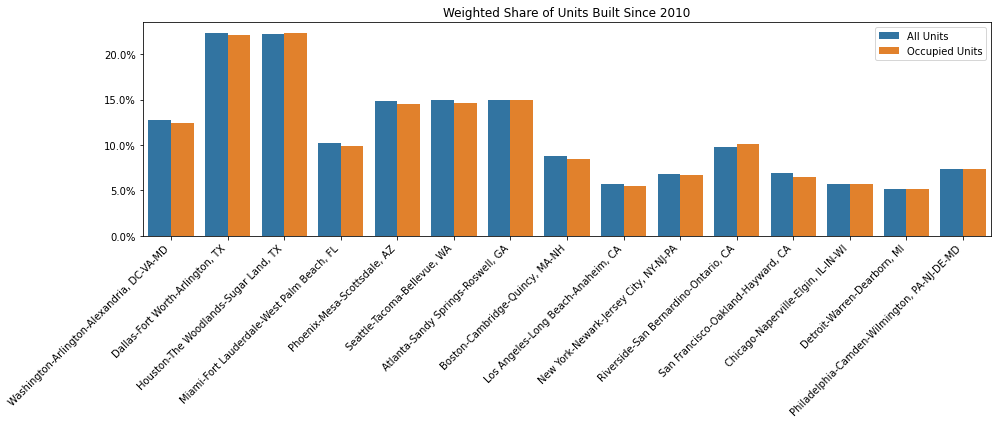

In [36]:
#Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='Metro', y='Share Built Since 2010', hue='Group')
plt.title("Weighted Share of Units Built Since 2010")
plt.xlabel("")
plt.ylabel("")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # treat y values as 0–1
plt.xticks(rotation=45, ha='right')
plt.legend(title="", loc='upper right')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/weighted_share_units_built_since_2010.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [37]:
# Create pivot table showing the share of units built since 2010
pivot_table_new_stock = plot_df.pivot_table(
    index='Metro',
    columns='Group',
    values='Share Built Since 2010'
)

# Optionally convert from proportions to percentages and round
pivot_table_new_stock = (pivot_table_new_stock * 100).round(2)
pivot_table_new_stock

Group,All Units,Occupied Units
Metro,,
"Washington-Arlington-Alexandria, DC-VA-MD",12.71,12.40
"Dallas-Fort Worth-Arlington, TX",22.38,22.14
"Houston-The Woodlands-Sugar Land, TX",22.19,22.39
"Miami-Fort Lauderdale-West Palm Beach, FL",10.24,9.85
"Phoenix-Mesa-Scottsdale, AZ",14.84,14.57
"Seattle-Tacoma-Bellevue, WA",14.98,14.59
"Atlanta-Sandy Springs-Roswell, GA",14.94,14.95
"Boston-Cambridge-Quincy, MA-NH",8.83,8.44
"Los Angeles-Long Beach-Anaheim, CA",5.69,5.46


## 1(a). How has the (weighted) share of rental units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?

The line graph will show the change in the share of renter-occupied housinf units from 2015 - 2023 by AMI.

In [38]:
#looking at the total weighted estimate of of renter-occupied units by metropolitan area from year to year
renter_df = metro_ami_panel_df[metro_ami_panel_df['TENURE'] == '2'].copy()

#cbsa_map = combine_all_cbsa_mappings()

# Ensure CBSA codes are strings before mapping
renter_df.loc[:, 'Metro'] = renter_df['OMB13CBSA'].astype(str).map(cbsa_map)

pivot_table = pd.pivot_table(
    renter_df,
    values='WEIGHT',
    index='Metro',
    columns='SRVYEAR',
    aggfunc='sum',
    fill_value=0
)

with pd.option_context('display.float_format', '{:,.0f}'.format):
    display(pivot_table)  

SRVYEAR,2015,2017,2019,2021,2023
Metro,,,,,
"Atlanta-Sandy Springs-Roswell, GA","696,401","777,610","754,331","808,232","775,578"
"Boston-Cambridge-Quincy, MA-NH","687,055","694,908","730,619","774,484","748,237"
"Chicago-Naperville-Elgin, IL-IN-WI","1,255,408","1,204,712","1,210,738","1,241,962","1,341,991"
"Dallas-Fort Worth-Arlington, TX","995,629","1,037,123","1,054,624","1,134,920","1,186,878"
"Detroit-Warren-Dearborn, MI","485,692","502,380","472,295","491,067","473,353"
"Houston-The Woodlands-Sugar Land, TX","866,180","866,200","876,843","1,025,627","1,052,278"
"Los Angeles-Long Beach-Anaheim, CA","2,267,207","2,240,640","2,265,472","2,416,401","2,427,746"
"Miami-Fort Lauderdale-West Palm Beach, FL","826,383","829,741","839,680","836,463","900,193"
"New York-Newark-Jersey City, NY-NJ-PA","3,509,656","3,524,499","3,643,812","3,671,932","3,760,537"


These weighted counts are much lower that ACS estimates. This is due to a few different reasons:
1. The ACS Measures People, The AHS Measures Units
    - ACS produces **person-weighted estimates**, so the renter population includes all people living in renter-occupied units.
    - AHS is unit-focused; it uses **housing unit weights**. Even if multiple people live in one unit, the AHS counts only the unit itself.
    - Example: In ACS, a household of 4 renters counts as 4 people. In AHS, it counts as 1 rental unit.

2. AHS Is a Sample of Units, Not a Full Cross-Section
    - AHS follows a **longitudinal sample of housing units**, which inherently limits how representative it can be at a point in time.
    - The **National AHS sample** is much smaller than ACS and is **designed to support national estimates only**, not granular geographic ones (unless using metro samples).

3. Coverage Differences
    - ACS includes **group quarters** (e.g., college dorms, prisons, nursing homes), some of which are rented by definition.
    - AHS **excludes institutional group quarters** altogether and is limited to standard housing units.

4. Time Frame and Rotating Panels in AHS
    - AHS is biennial and samples some metro areas only in select years. If you are using AHS metro samples, the renter counts will be much lower than in the ACS due to limited sample coverage.

5. Nonresponse Adjustment and Imputation
    - ACS has robust nonresponse adjustment and imputation techniques designed for annual population estimates.
    - AHS uses complex imputation too, but it’s more focused on longitudinal housing unit continuity, not annual population representativeness.

**Summary**:

The key reason the AHS weighted renter count is much lower than the ACS is because AHS counts housing units, not people, and it has a much smaller, longitudinal sample that excludes many unit types included in the ACS.
- Use ACS when you want population-level renter estimates.
- Use AHS when you're studying housing units, transitions, housing costs, or conditions over time.

In [39]:
#Define AMI category order
ami_order = ['Above LI', 'LI', 'VLI', 'ELI']
renter_df['AMI'] = pd.Categorical(renter_df['AMI'], categories=ami_order, ordered=True)

In [40]:
#Weighted count of renter-occupied housing units by year, AMI, and CBSA
ami_weighted = (
    renter_df
    .groupby(['SRVYEAR', 'AMI', 'OMB13CBSA'])['WEIGHT']
    .sum()
    .reset_index(name='ami_weighted_count')
)

In [41]:
#Total weighted renter-occupied housing units per year and CBSA (denominator)
total_weighted = (
    renter_df
    .groupby(['SRVYEAR', 'OMB13CBSA'])['WEIGHT']
    .sum()
    .reset_index(name='total_weighted')
)

In [42]:
#Merge numerator and denominator
ami_share = pd.merge(ami_weighted, total_weighted, on=['SRVYEAR', 'OMB13CBSA'])

In [43]:
#Filter only rows with valid AMI and CBSA mapping
cbsa_map_q1a = supply_cbsa_mapping()
ami_share = ami_share[ami_share['AMI'].notna() & ami_share['OMB13CBSA'].isin(cbsa_map_q1a.keys())]

In [44]:
#Calculate share
ami_share['share'] = ami_share['ami_weighted_count'] / ami_share['total_weighted']
ami_share['Metro'] = ami_share['OMB13CBSA'].map(cbsa_map_q1a)
ami_share['AMI'] = pd.Categorical(ami_share['AMI'], categories=ami_order, ordered=True)

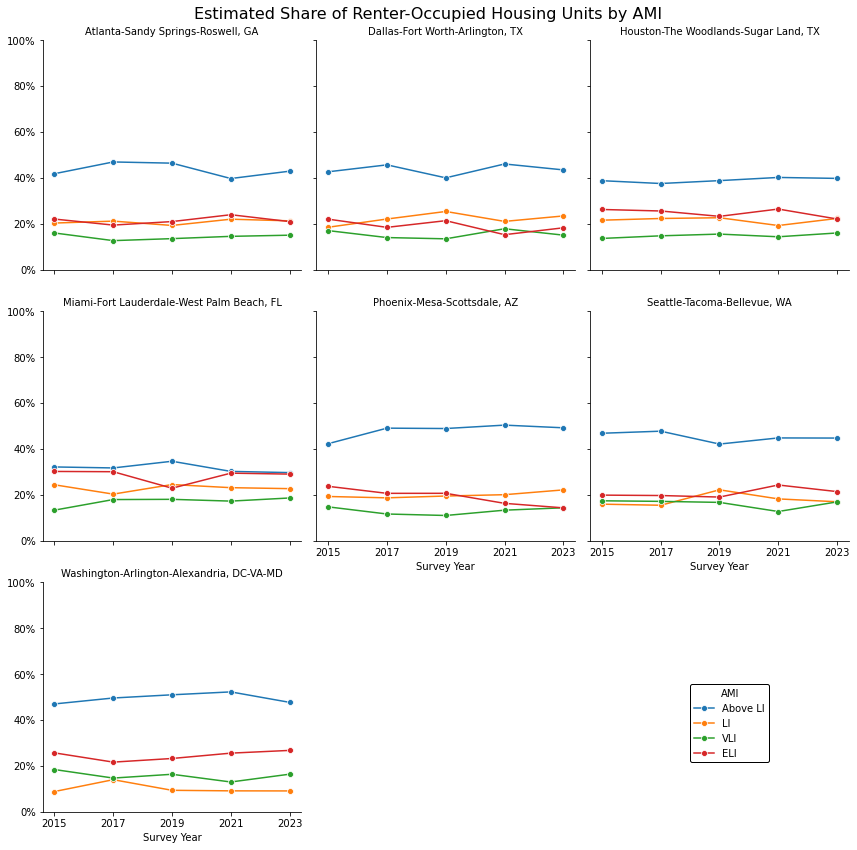

In [45]:
#Plot weighted share
g = sns.FacetGrid(
    ami_share,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='share', marker='o')

#Format plot axes and labels
g.set_axis_labels('Survey Year', '')
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

#Set consistent legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.9, 0.1)
)

#Remove redundant legends from individual facets
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Estimated Share of Renter-Occupied Housing Units by AMI', fontsize=16)

actual_years = [2015, 2017, 2019, 2021, 2023]
g.set(xticks=actual_years)

#Save and export image as png file
#g.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/estimated_share_renter_households_by_AMI.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [46]:
#Pivot table: Rows = Metro, Columns = SRVYEAR, Values = share (one table per AMI)
pivot_renter_share_ami = (
    ami_share
    .pivot_table(
        index='Metro',
        columns=['AMI', 'SRVYEAR'],
        values='share'
    )
    .sort_index(axis=1, level=[0, 1])
)

#Modifying 'pivot_renter_share_ami' to show rounded percentages
pivot_renter_share_ami_pct = (pivot_renter_share_ami * 100).round(2)

#view pivot table
with pd.option_context('display.max_columns', None):
    display(pivot_renter_share_ami_pct)  

AMI                                       Above LI                       \
SRVYEAR                                       2015   2017   2019   2021   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA            41.78  46.91  46.38  39.68   
Dallas-Fort Worth-Arlington, TX              42.62  45.64  39.98  46.03   
Houston-The Woodlands-Sugar Land, TX         38.74  37.51  38.77  40.16   
Miami-Fort Lauderdale-West Palm Beach, FL    32.15  31.71  34.63  30.20   
Phoenix-Mesa-Scottsdale, AZ                  42.30  49.06  48.90  50.38   
Seattle-Tacoma-Bellevue, WA                  46.84  47.74  42.12  44.80   
Washington-Arlington-Alexandria, DC-VA-MD    47.04  49.62  51.02  52.29   

AMI                                                  LI                       \
SRVYEAR                                     2023   2015   2017   2019   2021   
Metro                                                                          
Atlanta-Sandy Springs-Roswell, GA          42.89  20.27  21.11  19.23  21.95   
Dallas-Fort Worth-Arlington, TX            43.45  18.44  22.03  25.32  20.99   
Houston-The Woodlands-Sugar Land, TX       39.74  21.52  22.26  22.58  19.19   
Miami-Fort Lauderdale-West Palm Beach, FL  29.68  24.36  20.30  24.47  23.11   
Phoenix-Mesa-Scottsdale, AZ                49.22  19.26  18.68  19.47  20.05   
Seattle-Tacoma-Bellevue, WA                44.74  15.92  15.44  22.17  18.21   
Washington-Arlington-Alexandria, DC-VA-MD  47.72   8.84  14.01   9.37   9.14   

AMI                                                 VLI                       \
SRVYEAR                                     2023   2015   2017   2019   2021   
Metro                                                                          
Atlanta-Sandy Springs-Roswell, GA          21.23  15.94  12.60  13.47  14.47   
Dallas-Fort Worth-Arlington, TX            23.36  16.97  13.94  13.39  17.78   
Houston-The Woodlands-Sugar Land, TX       22.28  13.56  14.70  15.45  14.28   
Miami-Fort Lauderdale-West Palm Beach, FL  22.68  13.31  17.92  18.02  17.25   
Phoenix-Mesa-Scottsdale, AZ                22.14  14.74  11.63  10.98  13.29   
Seattle-Tacoma-Bellevue, WA                16.96  17.39  17.13  16.69  12.71   
Washington-Arlington-Alexandria, DC-VA-MD   9.10  18.43  14.71  16.36  13.00   

AMI                                                 ELI                       \
SRVYEAR                                     2023   2015   2017   2019   2021   
Metro                                                                          
Atlanta-Sandy Springs-Roswell, GA          14.98  22.01  19.38  20.92  23.90   
Dallas-Fort Worth-Arlington, TX            15.00  21.97  18.39  21.30  15.20   
Houston-The Woodlands-Sugar Land, TX       15.94  26.19  25.53  23.19  26.37   
Miami-Fort Lauderdale-West Palm Beach, FL  18.62  30.18  30.07  22.88  29.44   
Phoenix-Mesa-Scottsdale, AZ                14.34  23.70  20.64  20.65  16.27   
Seattle-Tacoma-Bellevue, WA                16.90  19.86  19.68  19.01  24.28   
Washington-Arlington-Alexandria, DC-VA-MD  16.40  25.70  21.66  23.25  25.58   

AMI                                               
SRVYEAR                                     2023  
Metro                                             
Atlanta-Sandy Springs-Roswell, GA          20.90  
Dallas-Fort Worth-Arlington, TX            18.19  
Houston-The Woodlands-Sugar Land, TX       22.04  
Miami-Fort Lauderdale-West Palm Beach, FL  29.02  
Phoenix-Mesa-Scottsdale, AZ                14.31  
Seattle-Tacoma-Bellevue, WA                21.39  
Washington-Arlington-Alexandria, DC-VA-MD  26.77

## 1(b). How has the (weighted) _count_ of rental units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?

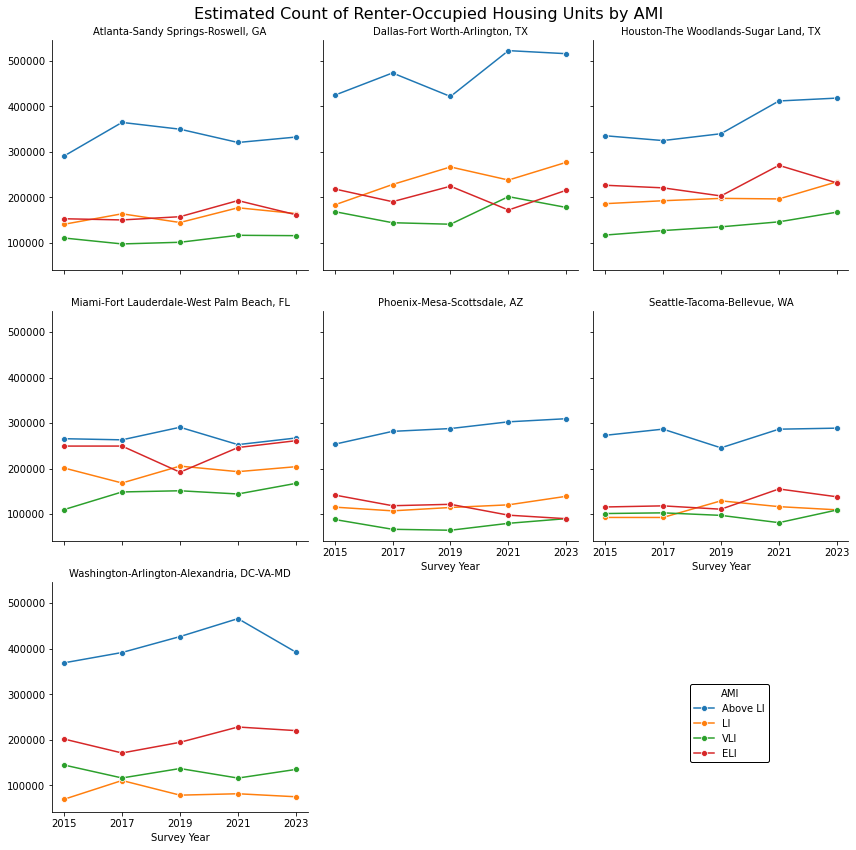

In [47]:
#plotting weighted count
g = sns.FacetGrid(
    ami_share,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='ami_weighted_count', marker='o')

#Format plot axes and labels
g.set_axis_labels('Survey Year', '')
g.set_titles(col_template="{col_name}")

#Set consistent legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.9, 0.1)
)

#Remove redundant legends from individual facets
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Estimated Count of Renter-Occupied Housing Units by AMI', fontsize=16)

actual_years = [2015, 2017, 2019, 2021, 2023]
g.set(xticks=actual_years)

#Save and export image as png file
#g.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/estimated_count_renter_households_by_AMI.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [48]:
#Pivot table: Rows = Metro, Columns = SRVYEAR, Values = share (one table per AMI)
pivot_renter_count_ami = (
    ami_share
    .pivot_table(
        index='Metro',
        columns=['AMI', 'SRVYEAR'],
        values='ami_weighted_count'
    )
    .sort_index(axis=1, level=[0, 1])
)

#view pivot table
with pd.option_context('display.max_columns', None):
    display(pivot_renter_count_ami)  

AMI                                             Above LI                 \
SRVYEAR                                             2015           2017   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA          290971.752169  364781.459385   
Dallas-Fort Worth-Arlington, TX            424339.718106  473364.808897   
Houston-The Woodlands-Sugar Land, TX       335536.526535  324923.013238   
Miami-Fort Lauderdale-West Palm Beach, FL  265641.388213  263141.950290   
Phoenix-Mesa-Scottsdale, AZ                253447.981577  281761.505292   
Seattle-Tacoma-Bellevue, WA                273015.815548  286643.972054   
Washington-Arlington-Alexandria, DC-VA-MD  368834.329507  391518.762307   

AMI                                                                      \
SRVYEAR                                             2019           2021   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA          349889.962871  320711.192995   
Dallas-Fort Worth-Arlington, TX            421682.003110  522388.946593   
Houston-The Woodlands-Sugar Land, TX       339955.133222  411846.258034   
Miami-Fort Lauderdale-West Palm Beach, FL  290765.456513  252644.955874   
Phoenix-Mesa-Scottsdale, AZ                287938.049455  302681.944519   
Seattle-Tacoma-Bellevue, WA                245584.719453  286538.261610   
Washington-Arlington-Alexandria, DC-VA-MD  426484.955899  465923.350509   

AMI                                                                  LI  \
SRVYEAR                                             2023           2015   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA          332620.304366  141143.800227   
Dallas-Fort Worth-Arlington, TX            515644.168188  183577.879747   
Houston-The Woodlands-Sugar Land, TX       418163.361905  186364.482320   
Miami-Fort Lauderdale-West Palm Beach, FL  267168.417707  201339.344481   
Phoenix-Mesa-Scottsdale, AZ                309567.065540  115427.988383   
Seattle-Tacoma-Bellevue, WA                288819.193201   92772.790913   
Washington-Arlington-Alexandria, DC-VA-MD  392196.353389   69289.449196   

AMI                                                                      \
SRVYEAR                                             2017           2019   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA          164147.238840  145033.240574   
Dallas-Fort Worth-Arlington, TX            228449.639651  267013.541608   
Houston-The Woodlands-Sugar Land, TX       192833.234722  198025.172769   
Miami-Fort Lauderdale-West Palm Beach, FL  168405.330019  205473.443729   
Phoenix-Mesa-Scottsdale, AZ                107256.746361  114634.509059   
Seattle-Tacoma-Bellevue, WA                 92725.370140  129242.099438   
Washington-Arlington-Alexandria, DC-VA-MD  110499.556355   78339.044577   

AMI                                                                      \
SRVYEAR                                             2021           2023   
Metro                                                                     
Atlanta-Sandy Springs-Roswell, GA          177388.480435  164675.275206   
Dallas-Fort Worth-Arlington, TX            238236.747138  277282.702850   
Houston-The Woodlands-Sugar Land, TX       196791.171994  234402.746698   
Miami-Fort Lauderdale-West Palm Beach, FL  193298.005421  204194.389062   
Phoenix-Mesa-Scottsdale, AZ                120438.872878  139247.167396   
Seattle-Tacoma-Bellevue, WA                116476.076081  109510.246385   
Washington-Arlington-Alexandria, DC-VA-MD   81415.825861   74790.383770   

AMI                                                  VLI                 \
SRVYEAR                                             2015           2017   
Metro                                                                     
Atlanta-Sandy Spring

## 1(c). What does the weighted count look like using hard-coded income buckets?

In [49]:
#Creating new DataFrame to analyze changes in the count of renter-occupied housing units by hard-coded income buckets
renter_income_buckets_df = metro_ami_panel_df[metro_ami_panel_df['TENURE'] == '2'].copy()

In [50]:
# Filter to CBSAs used in AMI analysis
# supply_cbsa_map = supply_cbsa_mapping()
# valid_cbsa = list(supply_cbsa_map.keys())
renter_income_buckets_df = renter_income_buckets_df[renter_income_buckets_df['OMB13CBSA'].isin(cbsa_map_q1a.keys())]#.copy()
renter_income_buckets_df['Metro'] = renter_income_buckets_df['OMB13CBSA'].map(cbsa_map_q1a)

In [51]:
# Define valid income bin edges and labels
earn_bins = (-float('inf'), 30000, 60000, 100000, 150000, 6445000)
earn_bin_lbl = (
    'Less than $30,000', #This captures $0 and <$0 incomes
    '\$30,000 - \$60,000', 
    '\$60,000 - \$100,000', 
    '\$100,000 - \$150,000', 
    'More than $150,000'
)

# Defining a new variable 'monthly earnings'
# Tip: Hold down shift and tab, and click on the command 'cut' to see more instructions from Python!
renter_income_buckets_df['INCOME'] = pd.cut(
    renter_income_buckets_df['HINCP'], 
    earn_bins, 
    labels=earn_bin_lbl
)

In [52]:
# Drop rows where income bucket is missing (outside defined bins or NaN)
#renter_income_buckets_df = renter_income_buckets_df[renter_income_buckets_df['INCOME'].notna()].copy()

In [53]:
grouped = (
    renter_income_buckets_df
    .groupby(['Metro', 'SRVYEAR', 'INCOME'])['WEIGHT']
    .sum()
    .reset_index(name='weighted_count')
)

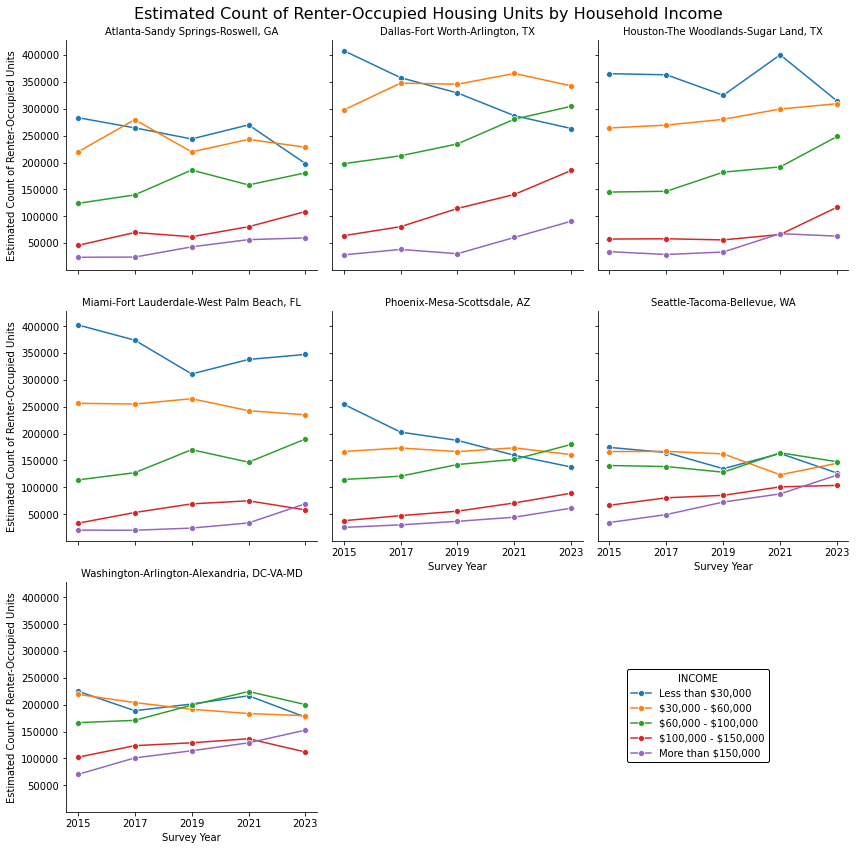

In [54]:
#plotting weighted count
g = sns.FacetGrid(
    grouped,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='INCOME',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='weighted_count', marker='o')

#Format plot axes and labels
g.set_axis_labels('Survey Year', 'Estimated Count of Renter-Occupied Units')
g.set_titles(col_template="{col_name}")

#Set consistent legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="INCOME",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.9, 0.1)
)

#Remove redundant legends from individual facets
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Estimated Count of Renter-Occupied Housing Units by Household Income', fontsize=16)

actual_years = [2015, 2017, 2019, 2021, 2023]
g.set(xticks=actual_years)

#Save and export image as png file
#g.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/estimated_count_renter_households_by_income.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [55]:
#Crosstab: Weighted count of renters by Metro × Income Bucket × Survey Year
crosstab = pd.crosstab(
    index=[renter_income_buckets_df['Metro'], renter_income_buckets_df['SRVYEAR']],
    columns=renter_income_buckets_df['INCOME'],
    values=renter_income_buckets_df['WEIGHT'],
    aggfunc='sum',
    margins=True
)

with pd.option_context('display.float_format', '{:,.0f}'.format):
    display(crosstab)  

INCOME                                             Less than $30,000  \
Metro                                     SRVYEAR                      
Atlanta-Sandy Springs-Roswell, GA         2015               283,636   
                                          2017               264,558   
                                          2019               243,873   
                                          2021               270,149   
                                          2023               198,028   
Dallas-Fort Worth-Arlington, TX           2015               408,429   
                                          2017               358,068   
                                          2019               329,580   
                                          2021               287,263   
                                          2023               263,350   
Houston-The Woodlands-Sugar Land, TX      2015               365,484   
                                          2017               363,419   
                                          2019               325,243   
                                          2021               400,664   
                                          2023               314,567   
Miami-Fort Lauderdale-West Palm Beach, FL 2015               402,551   
                                          2017               374,140   
                                          2019               311,199   
                                          2021               338,194   
                                          2023               347,583   
Phoenix-Mesa-Scottsdale, AZ               2015               254,793   
                                          2017               202,843   
                                          2019               187,489   
                                          2021               159,707   
                                          2023               137,846   
Seattle-Tacoma-Bellevue, WA               2015               174,390   
                                          2017               164,890   
                                          2019               134,754   
                                          2021               163,093   
                                          2023               126,579   
Washington-Arlington-Alexandria, DC-VA-MD 2015               225,343   
                                          2017               189,010   
                                          2019               201,405   
                                          2021               216,738   
                                          2023               176,972   
All                                                        9,165,830   

INCOME                                             \$30,000 - \$60,000  \
Metro                                     SRVYEAR                        
Atlanta-Sandy Springs-Roswell, GA         2015                 219,715   
                                          2017                 279,834   
                                          2019                 219,809   
                                          2021                 243,086   
                                          2023                 228,476   
Dallas-Fort Worth-Arlington, TX           2015                 297,785   
                                          2017                 347,898   
                                          2019                 345,853   
                                          2021                 365,888   
                                          2023                 342,785   
Houston-The Woodlands-Sugar Land, TX      2015                 264,317   
                                          2017                 269,759   
                                          2019                 280,396   
                                          2021                 299,690   
                                          2023                 309,557   
Miami

In [56]:
# Create pivot table: Rows = Metro, Columns = Income Bucket x SRVYEAR, Values = Weighted Count
pivot_renter_count_income = (
    renter_income_buckets_df
    .pivot_table(
        index='Metro',
        columns=['INCOME', 'SRVYEAR'],
        values='WEIGHT',
        aggfunc='sum',
        fill_value=0
    )
    .sort_index(axis=1, level=[0, 1])  # Sort by income_bucket, then SRVYEAR
)

# View the result
with pd.option_context('display.float_format', '{:,.0f}'.format, 'display.max_columns', None):
    display(pivot_renter_count_income)

INCOME                                    Less than $30,000                  \
SRVYEAR                                                2015    2017    2019   
Metro                                                                         
Atlanta-Sandy Springs-Roswell, GA                   283,636 264,558 243,873   
Dallas-Fort Worth-Arlington, TX                     408,429 358,068 329,580   
Houston-The Woodlands-Sugar Land, TX                365,484 363,419 325,243   
Miami-Fort Lauderdale-West Palm Beach, FL           402,551 374,140 311,199   
Phoenix-Mesa-Scottsdale, AZ                         254,793 202,843 187,489   
Seattle-Tacoma-Bellevue, WA                         174,390 164,890 134,754   
Washington-Arlington-Alexandria, DC-VA-MD           225,343 189,010 201,405   

INCOME                                                    \$30,000 - \$60,000  \
SRVYEAR                                      2021    2023                2015   
Metro                                                                           
Atlanta-Sandy Springs-Roswell, GA         270,149 198,028             219,715   
Dallas-Fort Worth-Arlington, TX           287,263 263,350             297,785   
Houston-The Woodlands-Sugar Land, TX      400,664 314,567             264,317   
Miami-Fort Lauderdale-West Palm Beach, FL 338,194 347,583             256,556   
Phoenix-Mesa-Scottsdale, AZ               159,707 137,846             166,709   
Seattle-Tacoma-Bellevue, WA               163,093 126,579             166,711   
Washington-Arlington-Alexandria, DC-VA-MD 216,738 176,972             219,433   

INCOME                                                                     \
SRVYEAR                                      2017    2019    2021    2023   
Metro                                                                       
Atlanta-Sandy Springs-Roswell, GA         279,834 219,809 243,086 228,476   
Dallas-Fort Worth-Arlington, TX           347,898 345,853 365,888 342,785   
Houston-The Woodlands-Sugar Land, TX      269,759 280,396 299,690 309,557   
Miami-Fort Lauderdale-West Palm Beach, FL 255,158 265,025 242,774 235,093   
Phoenix-Mesa-Scottsdale, AZ               173,327 166,532 173,631 160,864   
Seattle-Tacoma-Bellevue, WA               166,989 162,343 123,390 144,855   
Washington-Arlington-Alexandria, DC-VA-MD 204,087 191,633 183,719 179,631   

INCOME                                    \$60,000 - \$100,000          \
SRVYEAR                                                   2015    2017   
Metro                                                                    
Atlanta-Sandy Springs-Roswell, GA                      123,886 139,725   
Dallas-Fort Worth-Arlington, TX                        197,775 212,527   
Houston-The Woodlands-Sugar Land, TX                   145,005 146,394   
Miami-Fort Lauderdale-West Palm Beach, FL              113,808 127,239   
Phoenix-Mesa-Scottsdale, AZ                            114,576 120,769   
Seattle-Tacoma-Bellevue, WA                            140,668 138,747   
Washington-Arlington-Alexandria, DC-VA-MD              166,701 171,021   

INCOME                                                             \
SRVYEAR                                      2019    2021    2023   
Metro                                                               
Atlanta-Sandy Springs-Roswell, GA         185,989 158,237 180,792   
Dallas-Fort Worth-Arlington, TX           234,640 280,754 304,718   
Houston-The Woodlands-Sugar Land, TX      182,078 191,810 248,522   
Miami-Fort Lauderdale-West Palm Beach, FL 170,155 146,843 190,082   
Phoenix-Mesa-Scottsdale, AZ               142,505 152,113 179,922   
Seattle-Tacoma-Bellevue, WA               128,200 164,382 147,661   
Washington-Arlington-Alexandria, DC-VA-MD 199,325 224,725 200,409   

INCOME                                    \$100,000 - \$150,000          \
SRVYEAR                                                    2015    2017   
Metro                                        

## 2. To what extent does a housing unit stay occupied by an income group over time?
- Are more units filtering upward or downward?
- Of the units that filtered, what was the was the household income of the new occupant and how did their rent change?

This is intended to be a simpler analysis to that of Jonathan Spader's 2023 Research Paper: [Has Housing Filtering Stalled? Heterogeneous Outcomes in the American Housing Survey, 1985–2021](https://www.tandfonline.com/doi/pdf/10.1080/10511482.2023.2298256)

## 2(a). How has the percentage of units filtering to low-income Occupants changed in relation to units that have filtered for higher income from 2017 - 2023?

I am creating a dataframe of housing units ('CONTROL') throughout the survey waves/year ('SRVYEAR' == 2015, 2017, 2019, 2021, 2023) that have "turned over;" meaning that the unit had an occupant in x year but had a different occupant in y year. This will be defined as `'SAMEHHLD' =='3.0'` and `'HHMOVE' != year of the previous 'SRVYEAR'`. For example, there could be an observation where an housing unit occupant was present in 2017 and then in 2019 the same `'CONTROL'` observation had a flag that all household members are different than previous interview year (`'SAMEHHLD=='3.0'`). Then the `'HHMOVE'` year should not equal 2017 but could equal 2018 or 2019.

In [57]:
# #Filter survey waves/years
# srv_waves = [2015, 2017, 2019, 2021, 2023]
# renter_df_waves = renter_df[renter_df['SRVYEAR'].isin(srv_waves)].copy()

In [58]:
# #Ordering rows by 'CONTROL' and 'SRVYEAR', so each unit's observations are chronological
# renter_df_waves.sort_values(['CONTROL', 'SRVYEAR'], inplace=True)
# renter_df_waves[['CONTROL', 'SRVYEAR']]

In [59]:
# #Computing the previous 'SRVYEAR' within each 'CONTROL'. I'm doing this so confirm valid observations were 'SAMEHHLD' == '3'
# renter_df_waves['prev_srvyear'] = renter_df_waves.groupby('CONTROL')['SRVYEAR'].shift(1)
# renter_df_waves[['CONTROL', 'SRVYEAR', 'prev_srvyear']]

In [60]:
# #Identify observations that "turned over"
# turnover_mask = (
#     (renter_df_waves['SAMEHHLD'] == '3.0') &
#     (renter_df_waves['prev_srvyear'].notna()) &
#     (renter_df_waves['HHMOVE'] != renter_df_waves['prev_srvyear'])
# )
# turnover_mask.value_counts()

In [61]:
# #Create a DataFrame of units that turned over
# turnover_unit_df = renter_df_waves[turnover_mask].copy()

In [62]:
# #Filtering the DataFrame for observations within the "supply cohort"
# cbsa_codes_q2a = supply_cbsa_mapping()

# turnover_unit_df['Metro'] = turnover_unit_df['OMB13CBSA'].astype(str).map(cbsa_map)
# len(turnover_unit_df)

In [63]:
# #Define AMI order
# ami_order = ['Above LI', 'LI', 'VLI', 'ELI']
# turnover_unit_df['AMI'] = pd.Categorical(turnover_unit_df['AMI'], categories=ami_order, ordered=True)

In [64]:
# #I am "lagging" the weighted AMI since I am comparing AMI (income) from a previous occupant to a current occupant
# turnover_unit_df['AMI_prev'] = turnover_unit_df.groupby('CONTROL')['AMI'].shift(1)
# turnover_unit_df['WEIGHT_prev'] = turnover_unit_df.groupby('CONTROL')['WEIGHT'].shift(1)

By lagging AMI, I'm getting:
- `'AMI_prev'`: the income group of the household that lived in the unit in the previous wave
- `'AMI'`: the income group of the current household that just moved in

Then I can compare these two to detect whether the new occupant is from a higher or lower income group than the last.

In [65]:
# #Vectorized transition classification
# above_to_lower = (turnover_unit_df['AMI_prev'] == 'Above LI') & (turnover_unit_df['AMI'].isin(['LI', 'VLI', 'ELI']))
# lower_to_above = (turnover_unit_df['AMI_prev'].isin(['LI', 'VLI', 'ELI'])) & (turnover_unit_df['AMI'] == 'Above LI')

In [66]:
# dturnover_unit_dff['transition'] = pd.NA
# dturnover_unit_dff.loc[above_to_lower, 'transition'] = 'Above → Lower'
# dturnover_unit_dff.loc[lower_to_above, 'transition'] = 'Lower → Above'

In [67]:
# # Keep only transition rows
# dturnover_unit_dff = dturnover_unit_dff[turnover_unit_df['transition'].notna()]

In [68]:
# # Group and aggregate weights
# grouped = turnover_unit_df.groupby(['Metro', 'SRVYEAR', 'transition'], observed=True)['WEIGHT'].sum().reset_index(name='weighted_sum')
# total = turnover_unit_df.groupby(['Metro', 'SRVYEAR'], observed=True)['WEIGHT'].sum().reset_index(name='total_weight')

In [69]:
# # Merge and calculate percent
# merged = pd.merge(grouped, total, on=['Metro', 'SRVYEAR'])
# merged['percent'] = 100 * merged['weighted_sum'] / merged['total_weight']

In [70]:
# # Set up Seaborn aesthetics
# sns.set(style='whitegrid')

# # Create FacetGrid lineplot
# g = sns.FacetGrid(
#     merged,
#     col='Metro',
#     hue='transition',
#     col_wrap=3,
#     sharey=True,
#     height=4,
#     aspect=1.4
# )

# g.map(sns.lineplot, 'SRVYEAR', 'percent', marker='o')
# g.add_legend(title='Transition')
# g.set_axis_labels("Survey Year", "Percent of Turnover Units")
# g.set_titles("{col_name}")
# plt.subplots_adjust(top=0.92)
# g.fig.suptitle("Income Category Transitions After Unit Turnover (Weighted %)", fontsize=16)
# plt.show()

## 3(a). Changes in rent for renter-occupied households of market-rate units (i.e., unsubsidized, not income-restricted housing)
- How have rents changed for lower income households (<= 80% AMI) in relation to higher income households (>80 AMI)? 
- What is the percent change of rent for households in each income group over time (2015-2023)?
- Are rent increases higher for ELI, LI, or LI renters than for higher-income renters?

In [71]:
#Filter to unassisted renter households in market-rate units
unassisted_df = renter_df.loc[
    (renter_df['HUDSUB'] == '3') &
    (renter_df['RENTSUB'] == '8'),
    ['OMB13CBSA', 'SRVYEAR', 'RENT', 'AMI', 'WEIGHT']
].copy()

Dropping `'RENTCNTRL'` for this analysis becuase not all of the 15 metropolitan areas have valid responses since not all of them have rent control policies.

In [72]:
#Map CBSA codes to metro names
unassisted_df['OMB13CBSA'] = unassisted_df['OMB13CBSA'].astype(str)
unassisted_df['Metro'] = unassisted_df['OMB13CBSA'].map(supply_cbsa_mapping())
unassisted_df = unassisted_df.dropna(subset=['Metro'])

In [73]:
#Compute weighted rent components
unassisted_df['rent_x_weight'] = unassisted_df['RENT'] * unassisted_df['WEIGHT']

In [74]:
#Aggregate by Metro, AMI, SRVYEAR
agg = (
    unassisted_df
    .groupby(['Metro', 'AMI', 'SRVYEAR'], as_index=False)
    .agg(
        weighted_rent_num=('rent_x_weight', 'sum'),
        weighted_rent_den=('WEIGHT', 'sum')
    )
)

In [75]:
#Calculate weighted mean and % change in rent
agg['weighted_rent'] = agg['weighted_rent_num'] / agg['weighted_rent_den']
agg.sort_values(['Metro', 'AMI', 'SRVYEAR'], inplace=True)
agg['rent_pct_change'] = (
    agg.groupby(['Metro', 'AMI'])['weighted_rent']
    .pct_change() * 100
).round(2)

In [76]:
#Set AMI order
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
agg['AMI'] = pd.Categorical(agg['AMI'], categories=ami_order, ordered=True)

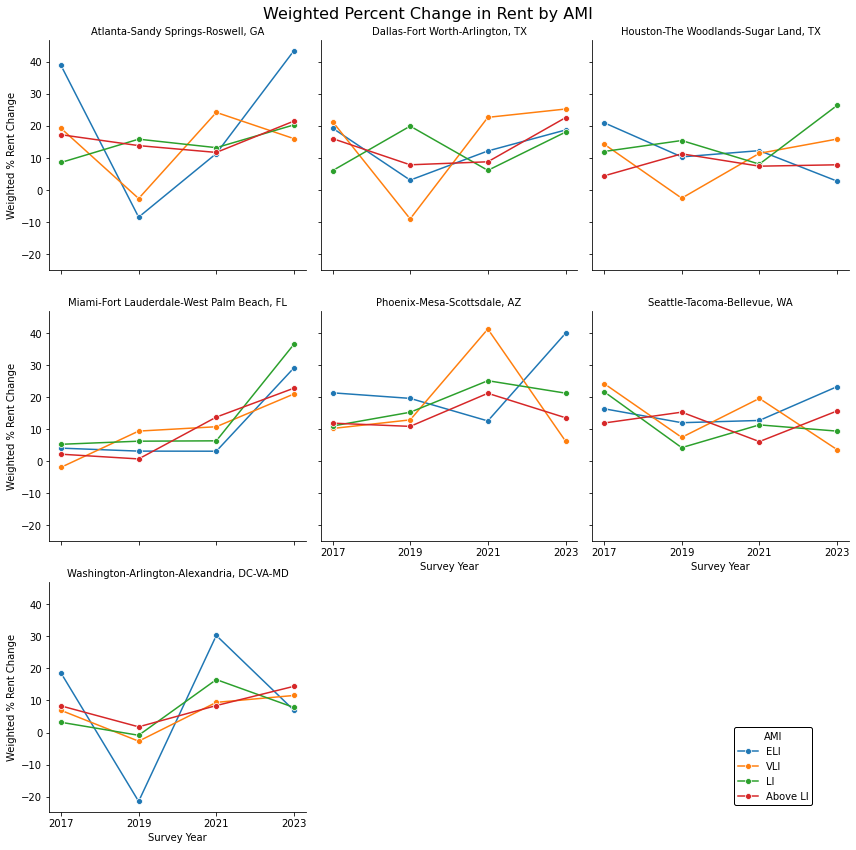

In [77]:
#Plot

g = sns.FacetGrid(
    agg, 
    col='Metro', 
    col_wrap=3, 
    height=4, 
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='rent_pct_change', marker='o')
g.set_titles("{col_name}")

# Set consistent axis labels
g.set_axis_labels("Survey Year", "Weighted % Rent Change")

# Set consistent x-ticks (for AHS: 2017, 2019, 2021, 2023)
for ax in g.axes.flat:
    ax.set_xticks([2017, 2019, 2021, 2023])
    ax.set_xticklabels([2017, 2019, 2021, 2023])

# Set a single legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.95, 0.05)
)

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Weighted Percent Change in Rent by AMI', fontsize=16)
plt.tight_layout()

#Save and export image as png file
#g.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/weighted_percent_rent_change_AMI.png', dpi=300, bbox_inches='tight')

plt.show()

This code is filtering the DataFrame to unassisted, market-rate renter households (based on `'HUDSUB'` and `'RENTSUB'`). This uses cross-sectional survey weights (`'WEIGHT'`) for each survey year to calculate weighted average rents and calculates percentage rent changes between years, within AMI groups and metros.

The plot shows:
- A trend showing how average rents for different income groups have changed in each market over time.

This is a repeated cross-sectional analysis — comparing point-in-time populations in 2017, 2019, 2021, and 2023.

This approach is valid when the goal is:
- To describe how market rent levels have changed for households in each AMI group at different points in time.

The use of `'WEIGHT'` is correct since it is being applied within each year, AMI group, and metro, which is exactly how cross-sectional weights are meant to be used.

This **_is not_** a longitudinal analysis since:
- Each year's rent data describes a different cross-sectional sample.
- The observed rent change could reflect:
    - Rent increases on the same units,
    - Turnover (new tenants paying different rents),
    - Composition shifts in who falls into each AMI group.

## 3(b). What is cumulative change in rent since 2015 by AMI? How have the average rents faced by different AMI groups in each metro changed relative to 2015, based on population-representative samples in each year?

In [78]:
#Calculate baseline rent (2015) for each Metro–AMI
base_rent = (
    agg[agg['SRVYEAR'] == 2015]
    .set_index(['Metro', 'AMI'])['weighted_rent']
    .rename('base_rent')
)

In [79]:
#Merge base_rent into full dataframe
agg = agg.merge(base_rent, on=['Metro', 'AMI'], how='left')

In [80]:
#Calculate cumulative rent change relative to 2015
agg['cumulative_rent_change'] = (
    (agg['weighted_rent'] / agg['base_rent']) - 1
) * 100

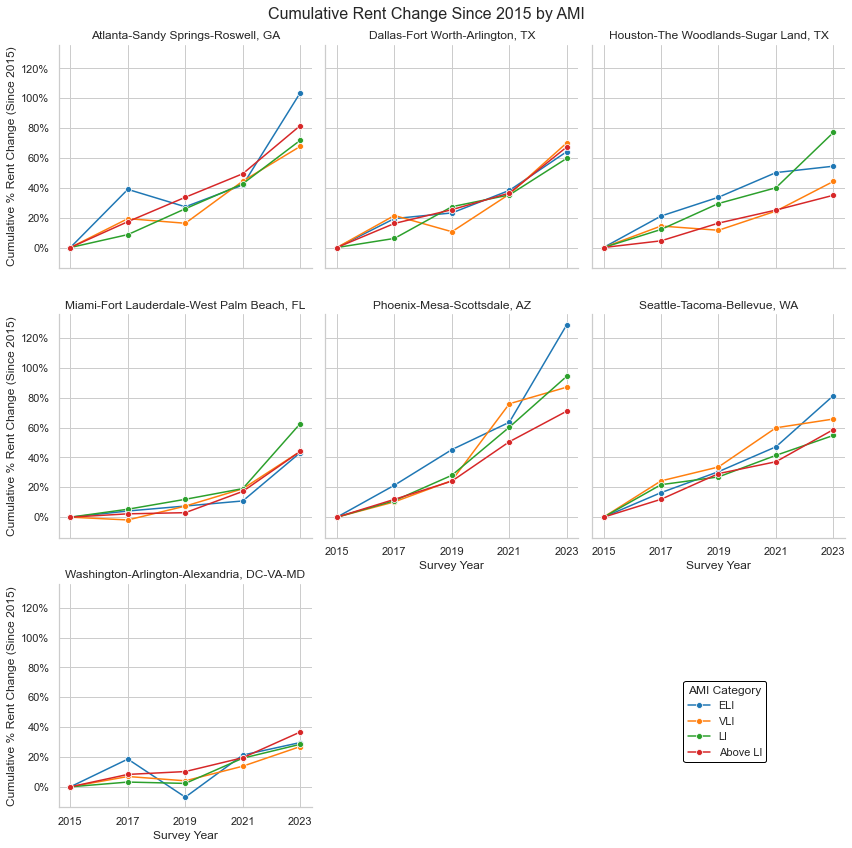

In [81]:
#Plot
sns.set(style="whitegrid")

g = sns.FacetGrid(
    agg,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(
    sns.lineplot,
    x='SRVYEAR',
    y='cumulative_rent_change',
    marker='o'
)

g.set_axis_labels("Survey Year", "Cumulative % Rent Change (Since 2015)")
g.set_titles("{col_name}")
g.set(xticks=[2015, 2017, 2019, 2021, 2023])

#Format y-axis as percentage
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(PercentFormatter(1.0 if agg['cumulative_rent_change'].max() < 1 else 100))

# Remove duplicate legends
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Single shared legend
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI Category",
    loc='lower right',
    bbox_to_anchor=(0.9, 0.1),
    frameon=True,
    edgecolor='black',
    framealpha=1
)

#Add overall title
g.fig.suptitle("Cumulative Rent Change Since 2015 by AMI", fontsize=16)
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.tight_layout()

#Save and export image as png file
#g.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/cumulative_rent_change.png', dpi=300, bbox_inches='tight')

plt.show()

This is repeated cross-sectional analysis, not longitudinal since it is calculating average rent within each year using cross-sectional weights (`'WEIGHT'`). Then it compares each year’s weighted average to the 2015 average. At no point are the same rental units being tracked over time.

This is valid and interpretable for:
- Describing aggregate market trends over time,
- Showing how rents have shifted for different types of renters (by AMI),
- Identifying distributional impacts of rent growth.

But it does not show:
- How rents changed for the same housing units,
- How specific households experienced rent change,
- The causal effect of time on rent in a panel structure.

## 4. What does the new rental stock look like? What are the rent levels for new units built since 2015? How have they changed? What income groups are occupying these new units?

In [82]:
# Filter to CBSAs in mapping only
cbsa_map_q4 = list(supply_cbsa_mapping().keys())

new_occupied_stock_df = metro_ami_panel_df[(metro_ami_panel_df['SRVYEAR'] == 2023) & 
                                           (metro_ami_panel_df['TENURE'] != '-6') & #Omitting vacant units from this DataFrame/analysis
                                           (metro_ami_panel_df['OMB13CBSA'].isin(cbsa_map_q4))
                                          ].copy()
len(new_occupied_stock_df)

12065

_Note:_ the 2023 DataFrame has 600 less observations because "units occupied w/o payment of rent" from the `'TENURE'` variable were dropped.
- Total observations with occupied units: 55,069
- Total observations with vacat units: 7,142

## 4(a). What is the size of newer housing units? Has there been a shift in the number of bedrooms per unit?

In [83]:
#Bucket bedrooms: top-code 4+
new_occupied_stock_df['BEDROOMS_GROUP'] = new_occupied_stock_df['BEDROOMS'].clip(upper=4).astype(int).astype(str)
new_occupied_stock_df.loc[new_occupied_stock_df['BEDROOMS_GROUP'] == '4', 'BEDROOMS_GROUP'] = '4+'

In [84]:
#Define binning conditions and corresponding bin labels
conditions = [
    new_occupied_stock_df['YRBUILT'] <= 1979, #This includes units buit before 1919 and other pre-coded decades
    new_occupied_stock_df['YRBUILT'].between(1980, 1989),
    new_occupied_stock_df['YRBUILT'].between(1990, 1999),
    new_occupied_stock_df['YRBUILT'].between(2000, 2009),
    new_occupied_stock_df['YRBUILT'].between(2010, 2023)
]

#Correcponding labels
bin_labels = [
    "1979 or earlier",
    "1980 - 1989",
    "1990 - 1999",
    "2000 - 2009",
    "2010 - 2023"
]

#Vectorized assignment to apply bins
new_occupied_stock_df['YRBUILT_BIN'] = np.select(conditions, bin_labels, default='Unknown')

In [85]:
#Ensure consistent plot order
new_occupied_stock_df['YRBUILT_BIN'] = pd.Categorical(
    new_occupied_stock_df['YRBUILT_BIN'],
    categories=[
        '1979 or earlier',
        '1980 - 1989',
        '1990 - 1999',
        '2000 - 2009',
        '2010 - 2023'
    ],
    ordered=True
)

In [86]:
#Calculate weighted percentage via group and pivot

def make_bedroom_pivot(df_sub):
    # Group by YRBUILT_BIN and BEDROOMS_GROUP
    g = df_sub.groupby(['YRBUILT_BIN', 'BEDROOMS_GROUP'])['WEIGHT'].sum().unstack(fill_value=0)

    # Normalize to get percentages
    g_percent = g.div(g.sum(axis=1), axis=0) * 100

    # Compute overall ("All Units") row
    total = df_sub.groupby('BEDROOMS_GROUP')['WEIGHT'].sum()
    total_percent = (total / total.sum()) * 100
    g_percent.loc['All Units'] = total_percent

    # Ensure consistent column order
    g_percent = g_percent[['0', '1', '2', '3', '4+']].fillna(0)

    return g_percent

In [87]:
#Split by tenure
owner_new_stock_df = new_occupied_stock_df[new_occupied_stock_df['TENURE'] == '1']
renter_new_stock_df = new_occupied_stock_df[new_occupied_stock_df['TENURE'] == '2']

owner_unit_pivot = make_bedroom_pivot(owner_new_stock_df)
renter_unit_pivot = make_bedroom_pivot(renter_new_stock_df)

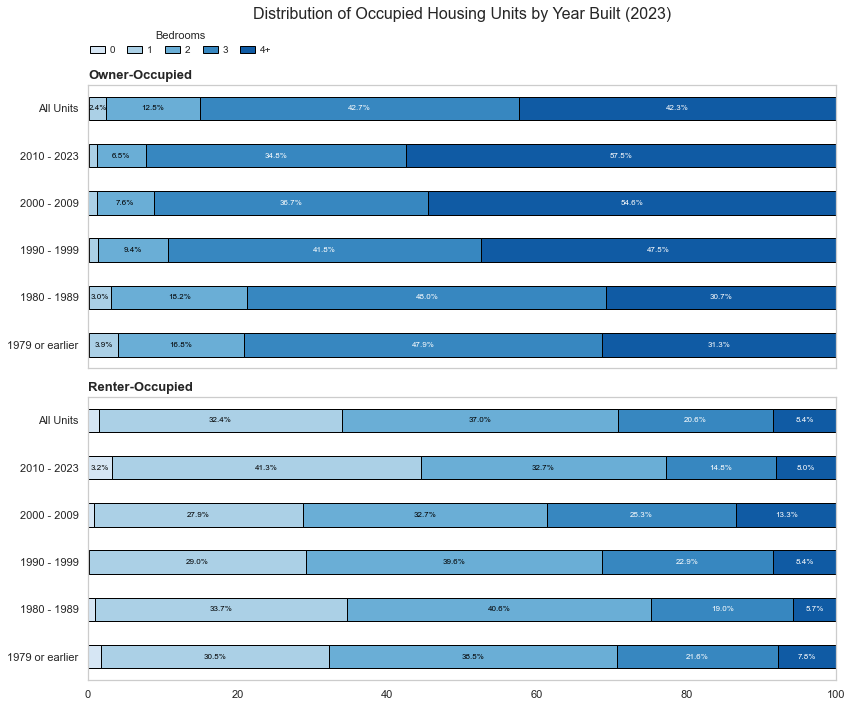

In [88]:
#Plotting

#Ensure consistent color mapping with darker blues for more bedrooms
bedroom_order = ['0', '1', '2', '3', '4+']
colors = sns.color_palette("Blues", n_colors=len(bedroom_order))

#Plot setup
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)
titles = ["Owner-Occupied", "Renter-Occupied"]
pivot_tables = [owner_unit_pivot[bedroom_order], renter_unit_pivot[bedroom_order]]

for ax, data, title in zip(axes, pivot_tables, titles):
    #Horizontal stacked bar plot
    data.plot(
        kind='barh',
        stacked=True,
        ax=ax,
        color=colors,
        edgecolor='black',
        legend=False  #Suppress legend for now
    )

    #Compute label positions (bar centers)
    centers = data.cumsum(axis=1) - data / 2

    #Loop through each bar section and annotate
    for col in data.columns:
        text_color = 'black' if col in ['0', '1', '2'] else 'white'
        for idx in range(len(data)):
            val = data.iloc[idx][col]
            if val > 2:  # Only label if >2%
                xpos = centers.iloc[idx][col]
                ax.text(
                    xpos, idx, f"{val:.1f}%",
                    va='center', ha='center',
                    fontsize=8, color=text_color
                )

    #Axis formatting
    ax.set_title(title, fontsize=13, fontweight='bold', loc='left')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(0, 100)  # Ensure bars reach 100%

#Shared legend above plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Bedrooms',
    loc='upper left',
    bbox_to_anchor=(0.10, 0.96),
    ncol=len(bedroom_order),
    frameon=False,
    fontsize=10,
    title_fontsize=11,
    handlelength=1.5,
    handletextpad=0.5,
    columnspacing=1.2
)

# Main title and layout
plt.suptitle("Distribution of Occupied Housing Units by Year Built (2023)", fontsize=16, x=0.30, ha='left')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/unit_size_overtime.png', dpi=300, bbox_inches='tight')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4(b). What size is the new housing stock? Is the newer supply of units in large or smaller buildings?

In [89]:
#Map BLD categories and labels
bld_map = {
    '2': 'One-Family House',
    '3': 'One-Family House',
    '4': '2 - 4 Units',
    '5': '2 - 4 Units',
    '6': '5 - 9 Units',
    '7': '10 - 49 Units',
    '8': '10 - 49 Units',
    '9': '50+ Units',
    '1': 'Mobile Home or Trailer, RV, Van, etc.',
    '10': 'Mobile Home or Trailer, RV, Van, etc.'
}

# Apply mapping vectorized using .map()
new_occupied_stock_df['BLD_BINNED'] = new_occupied_stock_df['BLD'].map(bld_map)

In [90]:
#Calculate weighted percentage via group and pivot
def make_bld_pivot(df_sub):
    #Define the full expected category list in the desired order
    expected_columns = [
        'One-Family House',
        '2 - 4 Units',
        '5 - 9 Units',
        '10 - 49 Units',
        '50+ Units',
        'Mobile Home or Trailer, RV, Van, etc.'
    ]

    #Group and pivot weighted values
    g = df_sub.groupby(['YRBUILT_BIN', 'BLD_BINNED'])['WEIGHT'].sum().unstack(fill_value=0)

    #Reindex to include all expected columns even if missing in data
    g = g.reindex(columns=expected_columns, fill_value=0)

    #Normalize to get row-wise percentages
    g_percent = g.div(g.sum(axis=1), axis=0) * 100

    #Add overall row
    total = df_sub.groupby('BLD_BINNED')['WEIGHT'].sum().reindex(expected_columns, fill_value=0)
    total_percent = (total / total.sum()) * 100
    g_percent.loc['All Units'] = total_percent

    return g_percent

In [91]:
owner_bld_pivot = make_bld_pivot(new_occupied_stock_df[new_occupied_stock_df['TENURE'] == '1'])
renter_bld_pivot = make_bld_pivot(new_occupied_stock_df[new_occupied_stock_df['TENURE'] == '2'])

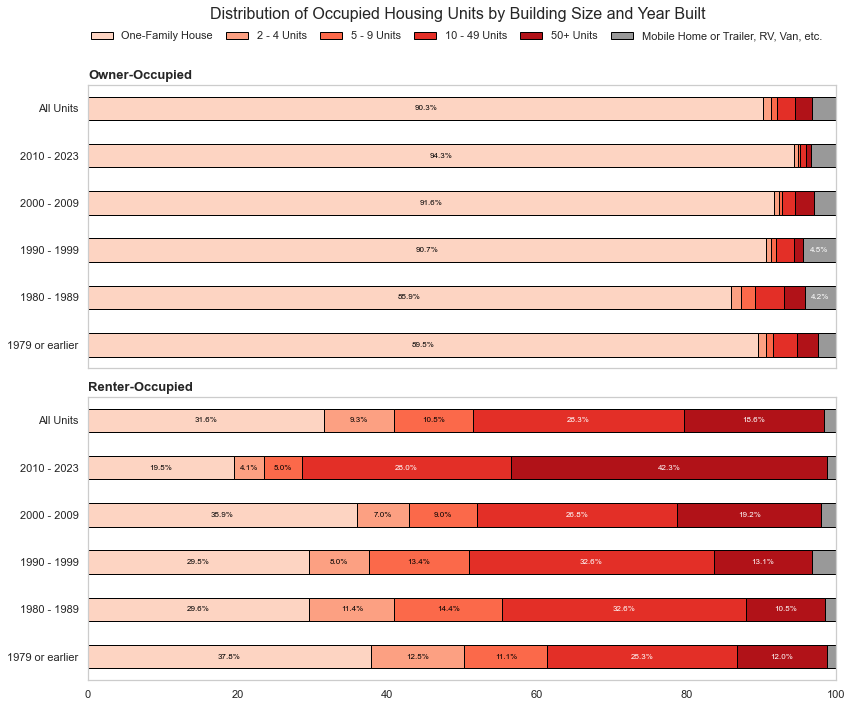

In [92]:
#Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

titles = ["Owner-Occupied", "Renter-Occupied"]
pivot_tables = [owner_bld_pivot, renter_bld_pivot]
category_order = owner_bld_pivot.columns.tolist()
colors = sns.color_palette("Reds", n_colors=5) + [(0.6, 0.6, 0.6)]  # Last one = gray

for ax, data, title in zip(axes, pivot_tables, titles):
    data = data[category_order]
    data.plot(
        kind='barh',
        stacked=True,
        ax=ax,
        color=colors,
        edgecolor='black',
        legend=False
    )

    centers = data.cumsum(axis=1) - data / 2
    for col in data.columns:
        text_color = 'black' if col in ['One-Family House', '2 - 4 Units', '5 - 9 Units'] else 'white'
        for idx in range(len(data)):
            val = data.iloc[idx][col]
            if val > 4:
                xpos = centers.iloc[idx][col]
                ax.text(
                    xpos, idx, f"{val:.1f}%",
                    va='center', ha='center',
                    fontsize=8, color=text_color
                )

    ax.set_title(title, fontsize=13, fontweight='bold', loc='left')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(0, 100)

# Legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='',
    title_fontsize=10,
    loc='upper left',
    bbox_to_anchor=(0.10, 0.96),
    frameon=False,
    ncol=len(labels),
    columnspacing=1.2
)

plt.suptitle("Distribution of Occupied Housing Units by Building Size and Year Built", fontsize=16, x=0.25, ha='left')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/bld_size_overtime.png', dpi=300, bbox_inches='tight')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4(c). What are the rent levels for the new housing stock compared to older units? 

In [93]:
#Map readable metropolitan area names
cbsa_map_q4c = supply_cbsa_mapping()
new_occupied_stock_df['Metro'] = new_occupied_stock_df['OMB13CBSA'].map(cbsa_map_q4c)

In [94]:
# Filter out invalid rent and weight values
filtered_rent_df = new_occupied_stock_df[
    (new_occupied_stock_df['RENT'] > 0) & 
    (new_occupied_stock_df['WEIGHT'] > 0)
]

In [95]:
#Set style and color palette
sns.set(style='whitegrid')
palette = sns.color_palette('vlag', as_cmap=True)

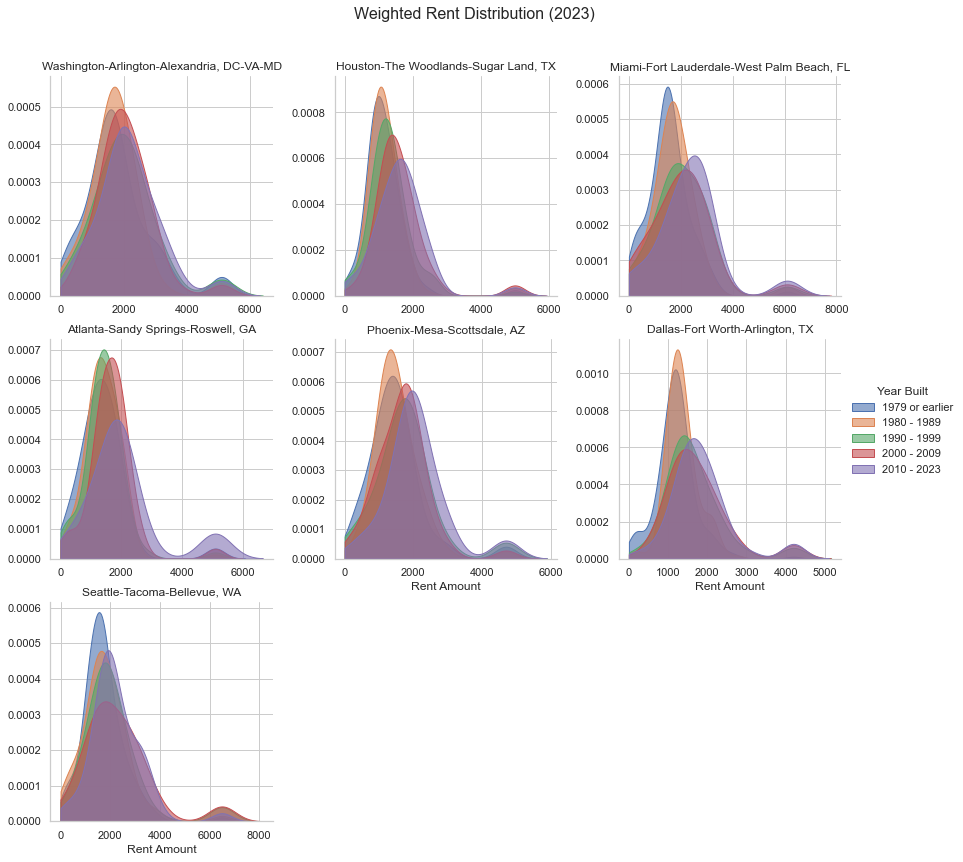

In [96]:
#Create FacetGrid with hue='YRBUILT_BIN'
g = sns.FacetGrid(
    filtered_rent_df, 
    col='Metro', 
    col_wrap=3, 
    height=4, 
    sharex=False, 
    sharey=False, 
    hue='YRBUILT_BIN'
)

#Plot directly using vectorized hue groups
g.map_dataframe(
    sns.kdeplot,
    x='RENT',
    weights='WEIGHT',
    fill=True,
    common_norm=False,
    alpha=0.6,
    linewidth=1,
    clip=(0, None)
)

#Labeling
g.add_legend(title="Year Built")
g.set_axis_labels("Rent Amount", "")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Weighted Rent Distribution (2023)", fontsize=16)

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/weighted_rent_distribution_2023.png', dpi=300, bbox_inches='tight')

plt.show()

**Key Takeaways:**
1. Most rents cluster between 1,000 – 2,500 across all metros.
    - This is where the density curves peak, regardless of year built.
2. Newer units (2010–2023, purple) tend to skew slightly rightward (i.e., higher rents), especially in:
    - Washington,  Miami, Seattle
    - This suggests newer housing is generally more expensive.
3. Older units (1979 or earlier, blue) show wider rent distributions in some metros:
    - For example, Seattle and shows older units with both low and high rent tails, possibly due to rent control or high variation in unit condition.
4. Bimodal curves (e.g., Seattle):
    - May reflect luxury vs affordable stock within the same vintage, or data outliers.
    - Boston has a sharp spike around ~2,000 and another peak past 10,000 for newer stock — could be high-end rentals or data anomalies.
5. Phoenix, Houston, and Atlanta show tighter distributions, suggesting more uniformity in rent pricing, especially among older units.
6. Dallas, Atlanta, and Houston (Sunbelt metros):
    - Show less variation across year-built categories.
    - Newer and older units are closer in rent distribution compared to coastal metros.
    
The distribution of rent prices for older buildings (like those built in 1979 or earlier) covers a larger range of values compared to newer buildings. This is visible in the KDE plot where the blue curve (representing older units) is flatter and more spread out — it doesn’t peak as sharply and has longer tails on both sides.

It suggests heterogeneity in the characteristics of older rental units. For example:
- Some older units are very affordable (possibly rent-controlled, subsidized, or in poorer condition).
- Others are expensive (perhaps they’ve been renovated, are in desirable neighborhoods, or are large historic homes).

## 4(d). How have the rents changed based on when the units was built?
This is a repeated cross-sectional analysis using log rent (`np.log(filtered_rent_change_df['RENT'])`), not a longitudinal analysis

In [97]:
#Apply mapping of Metro Area
cbsa_map_q4d = supply_cbsa_mapping()

#Filter data to included CBSAs only
filtered_rent_change_df = metro_ami_panel_df[
    (metro_ami_panel_df['OMB13CBSA'].isin(cbsa_map_q4d.keys())) &
    (metro_ami_panel_df['TENURE'] == '2') &  # renter-occupied only
    (metro_ami_panel_df['RENT'] > 0) #&
    #(metro_ami_panel_df['RENT'] < 15000)  # Optional: clip extreme values
].copy()

In [98]:
#Map readable metro names
filtered_rent_change_df['Metro'] = filtered_rent_change_df['OMB13CBSA'].map(cbsa_map_q4d)

In [99]:
filtered_rent_change_df['LOG_RENT'] = np.log(filtered_rent_change_df['RENT'])

In [100]:
#Define binning conditions and corresponding bin labels
conditions = [
    filtered_rent_change_df['YRBUILT'] <= 1979, #This includes units buit before 1919 and other pre-coded decades
    filtered_rent_change_df['YRBUILT'].between(1980, 1989),
    filtered_rent_change_df['YRBUILT'].between(1990, 1999),
    filtered_rent_change_df['YRBUILT'].between(2000, 2009),
    filtered_rent_change_df['YRBUILT'].between(2010, 2023)
]

#Correcponding labels
bin_labels = [
    "1979 or earlier",
    "1980 - 1989",
    "1990 - 1999",
    "2000 - 2009",
    "2010 - 2023"
]

#Vectorized assignment to apply bins
filtered_rent_change_df['YRBUILT_BIN'] = np.select(conditions, bin_labels, default='Unknown')

In [101]:
#Define the order of bins for consistency
yrbuilt_labels = [
    "1979 or earlier",
    "1980 - 1989",
    "1990 - 1999",
    "2000 - 2009",
    "2010 - 2023"
]

In [102]:
#Set Seaborn style
sns.set(style="whitegrid")
palette = sns.color_palette('vlag', as_cmap=True)

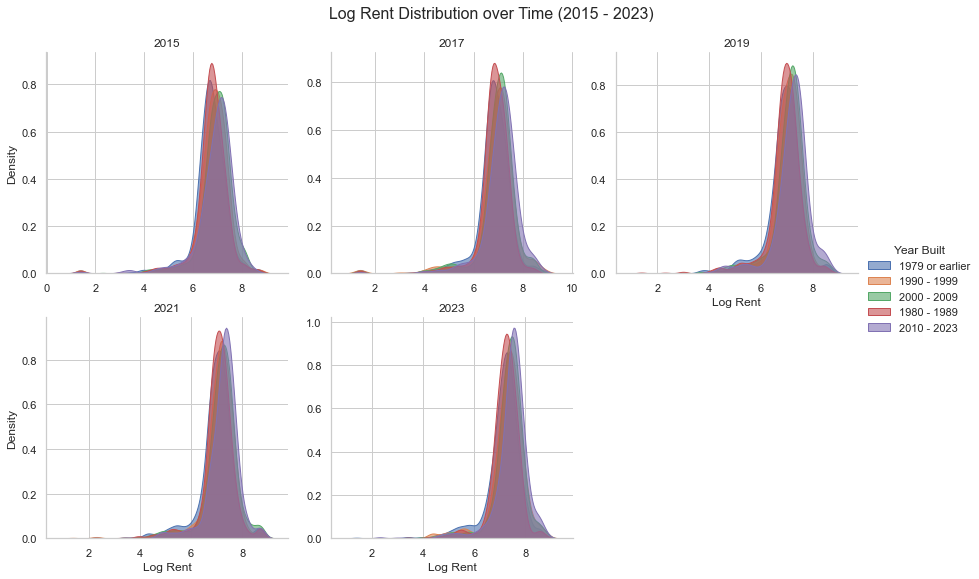

In [103]:
#Initialize FacetGrid
g = sns.FacetGrid(
    filtered_rent_change_df, 
    col='SRVYEAR', 
    col_wrap=3, 
    height=4, 
    sharex=False, 
    sharey=False,
    hue='YRBUILT_BIN'
)


#Plot directly using vectorized hue groups
g.map_dataframe(
    sns.kdeplot,
    x='LOG_RENT',
    weights='WEIGHT',
    fill=True,
    common_norm=False,
    alpha=0.6,
    linewidth=1
)

#Labeling
g.add_legend(title="Year Built")
g.set_axis_labels("Log Rent", "Density")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Log Rent Distribution over Time (2015 - 2023)", fontsize=16)

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/log_weighted_rent_distribution_over_time.png', dpi=300, bbox_inches='tight')

plt.show()

log(RENT) refers to the natural logarithm of the RENT variable — that is, the transformation of rent values using a logarithmic scale.

Why Use log(RENT)?
Rent values are typically right-skewed — a few units have very high rents that stretch the scale and distort comparisons. Taking the logarithm of rent:

- Compresses extreme high values (reduces skew)
- Spreads out lower values
- Makes the distribution more normal-like
- Improves interpretability in percentage terms (a 0.69 increase ≈ 100% increase)

How It’s Used in Analysis
- KDE Plots: log(RENT) gives smoother, more interpretable density curves.
- Regression: When used in models, coefficients can be interpreted as percentage changes.
- Trend Analysis: Easier to compare rent growth over time.

Key Observations from the Plot
- Across years, the center of the log rent distributions generally remains around 7.0–7.5 (which corresponds to raw rents of approx. 1,100–1,800).
- The shape and spread of the distributions are fairly consistent over time, though there's a slight shift rightward in later years (esp. 2021 and 2023), suggesting increasing rents.
- Newer buildings ("2010 – 2023") consistently show distributions skewed toward higher log rents, while older buildings are more concentrated in lower log rent ranges — consistent with the economic logic of depreciation and filtering.
- KDE plots are helpful here because they smooth out sampling noise and allow for visual comparison across multiple subgroups and time periods.


From visual inspection of the KDE plot — log(rent) appears to increase over time for older buildings (e.g., “1979 or earlier” and “1980 – 1989” bins).
- In 2015, the peaks (mode) for older buildings are centered around log(rent) ≈ 6.8–7.0.
- By 2023, those same curves shift slightly rightward, peaking closer to log(rent) ≈ 7.2–7.4.

This rightward shift indicates an increase in the log of rent, which also means an increase in actual rent.

In [104]:
# #Compute weighted median rents by SRVYEAR and YRBUILT_BIN
# def weighted_median(data, val_col, weight_col):
#     df_sorted = data.sort_values(val_col)
#     cumsum = df_sorted[weight_col].cumsum()
#     cutoff = df_sorted[weight_col].sum() / 2.0
#     return df_sorted[val_col][cumsum >= cutoff].iloc[0]

# grouped_medians = (
#     filtered_rent_change_df
#     .groupby(['SRVYEAR', 'YRBUILT_BIN'])
#     .apply(lambda x: weighted_median(x, 'RENT', 'WEIGHT'))
#     .reset_index(name='Weighted_Median_Rent')
# )

In [105]:
# #Line plot
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=grouped_medians, x='SRVYEAR', y='Weighted_Median_Rent', hue='YRBUILT_BIN', marker='o')
# plt.title("Weighted Median Rent Over Time")
# plt.xlabel("Survey Year")
# plt.ylabel("Weighted Median Rent")
# plt.legend(title="Year Built Bin")
# plt.tight_layout()
# plt.show()

In [106]:
# #Define chronological order
# year_order = [2015, 2017, 2019, 2021, 2023]

# plt.figure(figsize=(12, 6))
# sns.boxplot(
#     data=filtered_rent_change_df,
#     x='SRVYEAR',
#     y='RENT',
#     hue='YRBUILT_BIN',
#     order=year_order,
#     showfliers=False #outliers are excluded from plot
# )
# plt.title("Weighted Rent Distribution by Survey Year")
# plt.xlabel("Survey Year")
# plt.ylabel("Rent")
# plt.legend(title="Year Built", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

#### What happens if we limit the sample to housing units (`'CONTROL'`) that are in every survey wave/year(`'SRVYEAR'`)?

In [107]:
# #Identify panel units present in all survey waves
# panel_controls = filtered_rent_change_df.groupby("CONTROL")['SRVYEAR'].nunique()
# matched_controls = panel_controls[panel_controls == filtered_rent_change_df['SRVYEAR'].nunique()].index

In [108]:
# matched_controls

In [109]:
# #Comparing to original renter DataFrame
# len(filtered_rent_change_df)

In [110]:
# #Filter to panel units only
# rent_panel_df = filtered_rent_change_df[filtered_rent_change_df['CONTROL'].isin(matched_controls)].copy()
# len(rent_panel_df)

In [111]:
# rent_panel_df['CONTROL'].nunique()

In [112]:
# #Get 2015 weights and merge onto full panel
# weights_2015 = filtered_rent_change_df[filtered_rent_change_df['SRVYEAR'] == 2015][['CONTROL', 'WEIGHT']].rename(
#     columns={'WEIGHT': 'WEIGHT_2015'}
# )
# rent_panel_df = rent_panel_df.merge(weights_2015, on="CONTROL", how="left")

In [113]:
# # Plot KDEs using fixed 2015 weights
# g2 = sns.FacetGrid(rent_panel_df, col="SRVYEAR", col_wrap=3, height=4, sharex=True, sharey=True)

# def plot_kde_panel(data, **kwargs):
#     for bin_label in yrbuilt_labels:
#         subset = data[data['YRBUILT_BIN'] == bin_label]
#         if not subset.empty:
#             sns.kdeplot(
#                 data=subset,
#                 x="RENT",
#                 weights="WEIGHT_2015",
#                 label=bin_label,
#                 fill=True,
#                 common_norm=False,
#                 alpha=0.5,
#                 linewidth=1,
#                 **kwargs
#             )

# g2.map_dataframe(plot_kde_panel)
# g2.add_legend(title="Year Built")
# g2.set_axis_labels("Rent ($)", "Density")
# g2.set_titles("Survey Year: {col_name}")
# g2.fig.subplots_adjust(top=0.9)
# g2.fig.suptitle("Rent Distribution by Year Built (Longitudinal Sample, 2015 Weights)", fontsize=16)
# plt.tight_layout()
# plt.show()

In [114]:
# # Define your desired order (e.g., chronological)
# year_order = [2015, 2017, 2019, 2021, 2023]

# yrbuilt_order = [
#     "1979 or earlier",
#     "1980 - 1989",
#     "1990 - 1999",
#     "2000 - 2009",
#     "2010 - 2023"
# ]

# plt.figure(figsize=(12, 6))
# sns.boxplot(
#     data=rent_panel_df,
#     x='SRVYEAR',
#     y='RENT',
#     hue='YRBUILT_BIN',
#     order=year_order,
#     hue_order=yrbuilt_order,
#     showfliers=False
# )
# plt.title("Rent Distribution by Survey Year for Panel Units")
# plt.xlabel("Survey Year")
# plt.ylabel("Rent")
# plt.legend(title="Year Built", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

## 4(e). What income groups (`'AMI'`) are occupying new rental units?

In [115]:
#Apply mapping of Metro Area
cbsa_map_q4e = supply_cbsa_mapping()

#Isolating renter-occupied housing units
new_renter_occupied_stock_df = new_occupied_stock_df[(new_occupied_stock_df['TENURE'] == '2') &
                                                    (new_occupied_stock_df['OMB13CBSA'].isin(cbsa_map_q4e.keys()))
                                                    ].copy()

In [116]:
#Map readable metro names
new_renter_occupied_stock_df['Metro'] = new_renter_occupied_stock_df['OMB13CBSA'].map(cbsa_map_q4e)

In [117]:
#Group by YRBUILT_BIN and AMI, summing WEIGHT
grouped_ami_new_stock = new_renter_occupied_stock_df.groupby(['YRBUILT_BIN', 'AMI'])['WEIGHT'].sum().reset_index()

In [118]:
#Calculate weighted percentages within each YRBUILT_BIN
total_weight_by_bin = grouped_ami_new_stock.groupby('YRBUILT_BIN')['WEIGHT'].transform('sum')
grouped_ami_new_stock['percent'] = (grouped_ami_new_stock['WEIGHT'] / total_weight_by_bin) * 100

In [119]:
# Set order of bins and AMI levels
yrbuilt_order = ["1979 or earlier", "1980 - 1989", "1990 - 1999", "2000 - 2009", "2010 - 2023"]
ami_order = ['Above LI', 'LI', 'VLI', 'ELI']

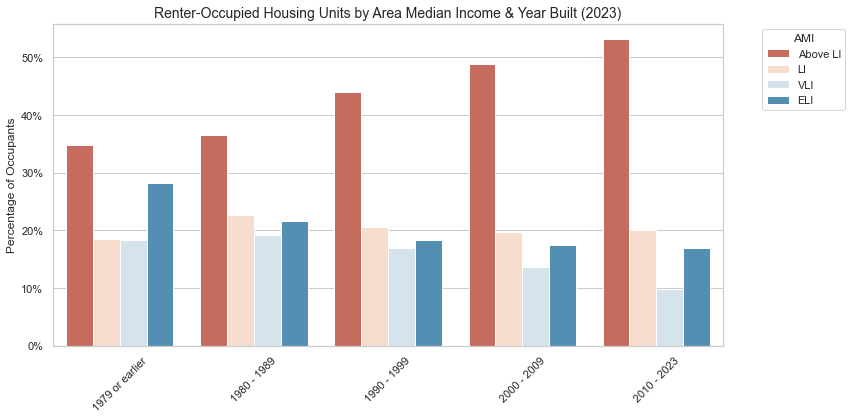

In [120]:
# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(
    data=grouped_ami_new_stock,
    x='YRBUILT_BIN',
    y='percent',
    hue='AMI',
    hue_order=ami_order,
    order=yrbuilt_order,
    palette='RdBu'
)

plt.title("Renter-Occupied Housing Units by Area Median Income & Year Built (2023)", fontsize=14)
plt.ylabel("Percentage of Occupants")
plt.xlabel("")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # treat y values as 0–1
plt.xticks(rotation=45)
plt.legend(title="AMI", bbox_to_anchor=(1.05, 1), loc='upper left')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/renter_unit_occupy_ami_year_built.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [121]:
#Pivot for table view
ami_new_stock_pivot_table = grouped_ami_new_stock.pivot(index='YRBUILT_BIN', columns='AMI', values='percent').fillna(0)
ami_new_stock_pivot_table

AMI,Above LI,ELI,LI,VLI
YRBUILT_BIN,,,,
1979 or earlier,34.807796,28.280850,18.504361,18.406993
1980 - 1989,36.494026,21.635316,22.706108,19.164551
1990 - 1999,44.017913,18.390109,20.573986,17.017993
2000 - 2009,48.898943,17.553902,19.812351,13.734804
2010 - 2023,53.168592,16.892265,20.056626,9.882517


## 5(a). Are vacancy rates higher for differet unit types (size, age)? Were the vacant units developed to rent at market rate?

#### Let's look at how vacancy rates have changed since 2015 

In [122]:
#Filtering only for Vacant renter and owner-occupied units
# vac_df = metro_ami_panel_df[metro_ami_panel_df['TENURE'] == '-6'].copy()
# occ_df = metro_ami_panel_df[metro_ami_panel_df['TENURE'].isin(['1', '2'])].copy()

In [123]:
# # Define metro mapping
# cbsa_map_q4c = combine_all_cbsa_mappings()

# # Map Metro only on these filtered dataframes
# vac_df['Metro'] = vac_df['OMB13CBSA'].map(cbsa_map_q4c)
# occ_df['Metro'] = occ_df['OMB13CBSA'].map(cbsa_map_q4c)

In [124]:
# # Optional: drop rows with missing Metro names (i.e., OMB13CBSA not in cbsa_map)
# vac_df = vac_df.dropna(subset=['Metro'])
# occ_df = occ_df.dropna(subset=['Metro'])

In [125]:
# #Numerator: weighted vacant units per metro/year
# vac_weighted = (
#     vac_df
#     .groupby(['Metro', 'SRVYEAR'])['WEIGHT']
#     .sum()
#     .reset_index(name='vacant_weighted')
# )

In [126]:
# #Denominator: total occupied housing stock per metro/year
# occ_weighted = (
#     occ_df
#     .groupby(['Metro', 'SRVYEAR'])['WEIGHT']
#     .sum()
#     .reset_index(name='occupied_weighted')
# )

In [127]:
# #Merge numerator and denominator
# merged = pd.merge(vac_weighted, occ_weighted, on=['Metro', 'SRVYEAR'], how='inner')

In [128]:
# merged['total_weighted'] = merged['occupied_weighted'] + merged['vacant_weighted']

In [129]:
# merged['vacancy_rate'] = (merged['vacant_weighted'] / merged['total_weighted']) * 100

In [130]:
# #Pivot to compare 2015 vs 2023
# metro_vac_pivot = merged.pivot(index='Metro', columns='SRVYEAR', values='vacancy_rate')

In [131]:
# #Calculate **percentage point** change
# metro_vac_pivot['Pct_Point_Change_2015_2023'] = (metro_vac_pivot[2023] - metro_vac_pivot[2015]).round(2)

In [132]:
# metro_vac_pivot

In [133]:
# # Filter for the CBSA of interest
# filtered_df = vac_df[vac_df['OMB13CBSA'] == '33100']

# # Group and aggregate both count and average weight
# result = (
#     filtered_df
#     .groupby(['OMB13CBSA', 'SRVYEAR', 'TENURE'])
#     .agg(
#         count=('TENURE', 'size'),
#         avg_weight=('WEIGHT', 'mean')
#     )
#     .reset_index()
# )

# print(result)

In [134]:
# #Calculate for all metros
# total_vac = vac_df.groupby('SRVYEAR')['WEIGHT'].sum()
# total_occ = occ_df.groupby('SRVYEAR')['WEIGHT'].sum()
# total_vac_rate = (total_vac / total_occ * 100).round(2)
# total_change = round(total_vac_rate[2023] - total_vac_rate[2015], 2)

In [135]:
# #Add All Metros row
# metro_vac_pivot.loc['All Metros'] = [
#     total_vac_rate.get(2015, None),
#     total_vac_rate.get(2017, None),
#     total_vac_rate.get(2019, None),
#     total_vac_rate.get(2021, None),
#     total_vac_rate.get(2023, None),
#     total_change
# ]

In [136]:
# #Sort and move "All Metros" to bottom
# sorted_vac_pivot = metro_vac_pivot.dropna(subset=['Pct_Point_Change_2015_2023']).copy()
# sorted_vac_pivot = sorted_vac_pivot.sort_values('Pct_Point_Change_2015_2023', ascending=True)
# if 'All Metros' in sorted_vac_pivot.index:
#     all_row = sorted_vac_pivot.loc[['All Metros']]
#     sorted_vac_pivot = sorted_vac_pivot.drop('All Metros')
#     sorted_vac_pivot = pd.concat([sorted_vac_pivot, all_row])

In [137]:
# #Plot
# plt.figure(figsize=(10, 6))
# bars = plt.barh(sorted_vac_pivot.index, sorted_vac_pivot['Pct_Point_Change_2015_2023'], color='skyblue')

# plt.title('Change in Weighted Vacancy Rate (Percentage Points), 2015 to 2023', fontsize=14)
# plt.xlabel('Percentage Point Change', fontsize=12)
# plt.ylabel('')

# #Annotate bars
# for bar in bars:
#     width = bar.get_width()
#     plt.annotate(f'{width:.1f}%', 
#                  xy=(width, bar.get_y() + bar.get_height() / 2),
#                  xytext=(5, 0),
#                  textcoords='offset points',
#                  ha='left', va='center')

# plt.tight_layout()
# plt.show()

### I CAN'T GET THE MATH/CODE RIGHT TO CALCULATE CHANGE IN VACANCY...Will OMIT IF I CAN"T FIGURE IT OUT

## 5(b). Are newer units more likely to be vacant then the overall housing stock?

In [138]:
# Define metro mapping
cbsa_map_q5b = combine_all_cbsa_mappings()

In [139]:
# Filter for 2023 and relevant CBSAs
new_construction_df = metro_ami_panel_df[
    (metro_ami_panel_df['SRVYEAR'] == 2023) &
    (metro_ami_panel_df['OMB13CBSA'].isin(cbsa_map_q5b.keys()))
].copy()

In [140]:
# Map Metro names
new_construction_df['Metro'] = new_construction_df['OMB13CBSA'].map(cbsa_map_q5b)

In [141]:
# Flag for built since 2010
new_construction_df['built_since_2010'] = (new_construction_df['YRBUILT'] >= 2010).astype(int)

In [142]:
# Separate out vacant and total units (vacant + occupied)
vacant_df = new_construction_df[new_construction_df['TENURE'] == '-6'].copy()
total_df = new_construction_df[new_construction_df['TENURE'].isin(['1', '2', '-6'])].copy()

In [143]:
#Weighted count of vacant units by metro and build year
# Group by Metro and built_since_2010
vacant_weighted = (
    vacant_df
    .groupby(['Metro', 'built_since_2010'])['WEIGHT']
    .sum()
    .reset_index(name='vacant_weighted')
)

In [144]:
#Total vacant units per metro (all build years)
total_weighted = (
    total_df
    .groupby(['Metro', 'built_since_2010'])['WEIGHT']
    .sum()
    .reset_index(name='total_weighted')
)

In [145]:
# Merge and compute percentage vacant
vacancy_rate = pd.merge(vacant_weighted, total_weighted, on=['Metro', 'built_since_2010'])
vacancy_rate['Percent Vacant'] = (vacancy_rate['vacant_weighted'] / vacancy_rate['total_weighted']) * 100
vacancy_rate['Group'] = vacancy_rate['built_since_2010'].map({0: 'Built Before 2010', 1: 'Built Since 2010'})

In [146]:
# Calculate "All Metros"
all_metros_vacant = (
    vacant_df
    .groupby('built_since_2010')['WEIGHT']
    .sum()
    .reset_index(name='vacant_weighted')
)

In [147]:
all_metros_total = (
    total_df
    .groupby('built_since_2010')['WEIGHT']
    .sum()
    .reset_index(name='total_weighted')
)

In [148]:
all_metros_rate = pd.merge(all_metros_vacant, all_metros_total, on='built_since_2010')
all_metros_rate['Percent Vacant'] = (all_metros_rate['vacant_weighted'] / all_metros_rate['total_weighted']) * 100
all_metros_rate['Group'] = all_metros_rate['built_since_2010'].map({0: 'Built Before 2010', 1: 'Built Since 2010'})
all_metros_rate['Metro'] = 'All 15 Metros'

In [149]:
# Combine into final DataFrame
final_df = pd.concat([vacancy_rate, all_metros_rate], ignore_index=True)

In [150]:
# Sort so "All Metros" is last
ordered_metros = final_df['Metro'].drop_duplicates().sort_values().tolist()
if 'All 15 Metros' in ordered_metros:
    ordered_metros.remove('All 15 Metros')
    ordered_metros.append('All 15 Metros')

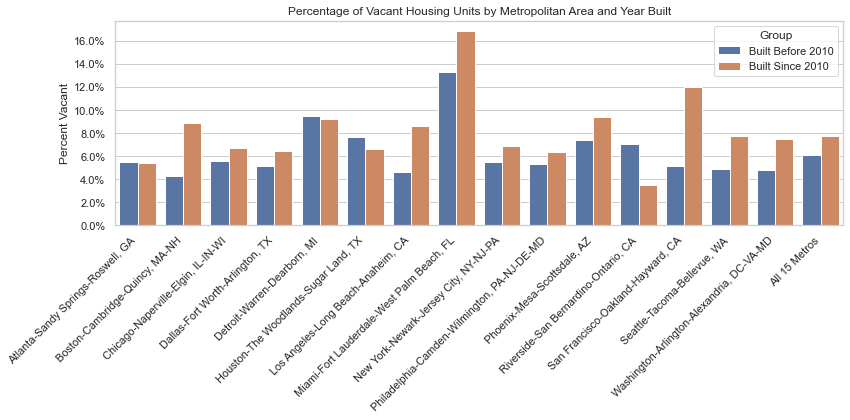

In [151]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=final_df, x='Metro', y='Percent Vacant', hue='Group', order=ordered_metros)
plt.title("Percentage of Vacant Housing Units by Metropolitan Area and Year Built")
plt.xlabel("")
plt.ylabel("Percent Vacant")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # treat y values as 0–1
plt.xticks(rotation=45, ha='right')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/percent_units_vacant.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [152]:
# Create pivot table
new_vac_pivot = final_df.pivot_table(
    index='Metro',
    columns='Group',
    values='Percent Vacant',
    aggfunc='first'  # there should be one value per group
).reset_index()

# Optional: reorder columns for readability
new_vac_pivot = new_vac_pivot[['Metro', 'Built Before 2010', 'Built Since 2010']]
new_vac_pivot

Group,Metro,Built Before 2010,Built Since 2010
0,All 15 Metros,6.148050,7.723365
1,"Atlanta-Sandy Springs-Roswell, GA",5.463835,5.423193
2,"Boston-Cambridge-Quincy, MA-NH",4.254897,8.869742
3,"Chicago-Naperville-Elgin, IL-IN-WI",5.555666,6.743428
4,"Dallas-Fort Worth-Arlington, TX",5.137120,6.422666
5,"Detroit-Warren-Dearborn, MI",9.503327,9.228294
6,"Houston-The Woodlands-Sugar Land, TX",7.678756,6.620792
7,"Los Angeles-Long Beach-Anaheim, CA",4.614893,8.648227
8,"Miami-Fort Lauderdale-West Palm Beach, FL",13.295553,16.897925
9,"New York-Newark-Jersey City, NY-NJ-PA",5.489171,6.873612


## 5(c). Of all vacant units within the "supply" metros, is the share of vacant housing units concentrated in building type and age of units.

In [153]:
# Filter to CBSAs in mapping only
included_cbsas_q5c = list(supply_cbsa_mapping().keys())

new_vac_stock_df = metro_ami_panel_df[(metro_ami_panel_df['SRVYEAR'] == 2023) & 
                                           (metro_ami_panel_df['TENURE'] == '-6') & #Vacant units
                                           (metro_ami_panel_df['OMB13CBSA'].isin(included_cbsas_q5c))
                                          ].copy()
len(new_vac_stock_df)

1689

In [154]:
#Define binning conditions and corresponding bin labels
vac_conditions = [
    new_vac_stock_df['YRBUILT'] <= 1979, #This includes units buit before 1919 and other pre-coded decades
    new_vac_stock_df['YRBUILT'].between(1980, 1989),
    new_vac_stock_df['YRBUILT'].between(1990, 1999),
    new_vac_stock_df['YRBUILT'].between(2000, 2009),
    new_vac_stock_df['YRBUILT'].between(2010, 2023)
]

#Correcponding labels
vac_bin_labels = [
    "1979 or earlier",
    "1980 - 1989",
    "1990 - 1999",
    "2000 - 2009",
    "2010 - 2023"
]

#Vectorized assignment to apply bins
new_vac_stock_df['YRBUILT_BIN'] = np.select(vac_conditions, vac_bin_labels, default='Unknown')

In [155]:
#Map BLD categories and labels
vac_bld_map = {
    '2': 'One-Family House',
    '3': 'One-Family House',
    '4': '2 - 4 Units',
    '5': '2 - 4 Units',
    '6': '5 - 9 Units',
    '7': '10 - 49 Units',
    '8': '10 - 49 Units',
    '9': '50+ Units',
    '1': 'Mobile Home or Trailer, RV, Van, etc.',
    '10': 'Mobile Home or Trailer, RV, Van, etc.'
}

# Apply mapping vectorized using .map()
new_vac_stock_df['BLD_BINNED'] = new_vac_stock_df['BLD'].map(bld_map)

In [156]:
#Calculate weighted percentage via group and pivot
def make_vac_bld_pivot(df_sub):
    #Define the full expected category list in the desired order
    expected_columns = [
        'One-Family House',
        '2 - 4 Units',
        '5 - 9 Units',
        '10 - 49 Units',
        '50+ Units',
        'Mobile Home or Trailer, RV, Van, etc.'
    ]

    #Group and pivot weighted values
    g = df_sub.groupby(['YRBUILT_BIN', 'BLD_BINNED'])['WEIGHT'].sum().unstack(fill_value=0)

    #Reindex to include all expected columns even if missing in data
    g = g.reindex(columns=expected_columns, fill_value=0)

    #Normalize to get row-wise percentages
    g_percent = g.div(g.sum(axis=1), axis=0) * 100

    #Add overall row
    total = df_sub.groupby('BLD_BINNED')['WEIGHT'].sum().reindex(expected_columns, fill_value=0)
    total_percent = (total / total.sum()) * 100
    g_percent.loc['All Units'] = total_percent

    return g_percent

In [157]:
vac_bld_pivot = make_vac_bld_pivot(new_vac_stock_df)

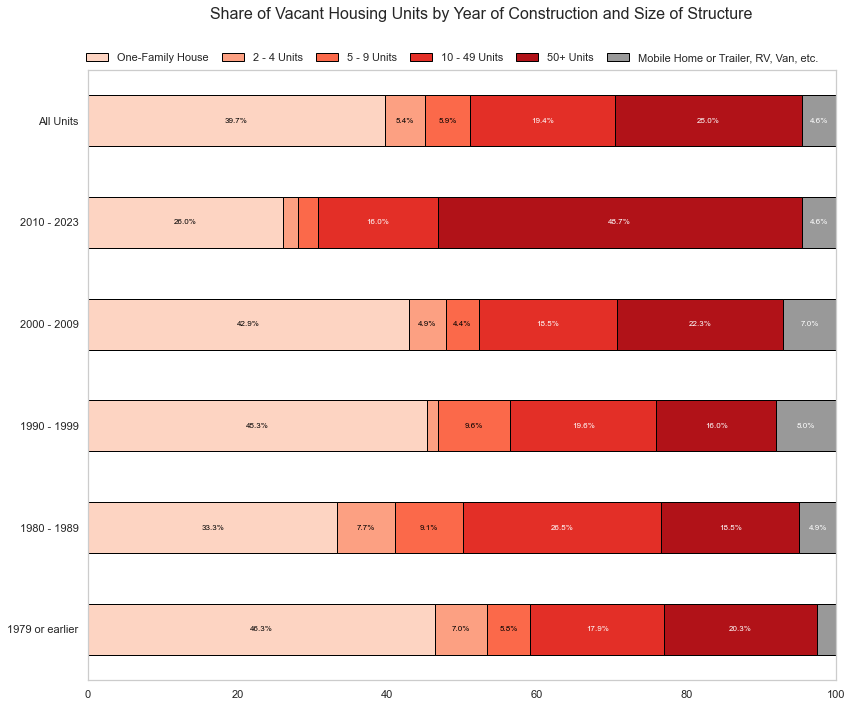

In [158]:
#Plotting
fig, ax = plt.subplots(figsize=(12, 10))
colors = sns.color_palette("Reds", n_colors=5) + [(0.6, 0.6, 0.6)]  # Last one = gray

vac_bld_pivot.plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=colors, 
    edgecolor='black', 
    legend=False
)

#Labeling
centers = vac_bld_pivot.cumsum(axis=1) - vac_bld_pivot / 2
for col in vac_bld_pivot.columns:
    text_color = 'black' if col in ['One-Family House', '2 - 4 Units', '5 - 9 Units'] else 'white'
    for idx in range(len(vac_bld_pivot)):
        val = vac_bld_pivot.iloc[idx][col]
        if val > 4:
            xpos = centers.iloc[idx][col]
            ax.text(
                xpos, idx, f"{val:.1f}%",
                va='center', ha='center',
                fontsize=8, color=text_color
            )

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlim(0, 100)

#Legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='',
    title_fontsize=10,
    loc='upper left',
    bbox_to_anchor=(0.095, 0.93),
    frameon=False,
    ncol=len(labels),
    columnspacing=1.2
)

plt.suptitle("Share of Vacant Housing Units by Year of Construction and Size of Structure", fontsize=16, x=0.25, ha='left')

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/units_vacant_size_age.png', dpi=300, bbox_inches='tight')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 5(d). Of vacant rental units, what is the rent distribution by building age?

#### A few notes on vacancy analysis:
- I am limiting the observations under the `'VACANCY'` variable to the `01` (For rent only) and `02` (For rent or for sale) codes. However, I am only including `02` observations if `'RENT' > 0`. (`n == 15,317`) for that observation in the panel dataset.
- Observations where `'VACANCY' == '03'` (For sale only) are not included for this analysis becuase corresponding housing cost variables (`'MORTAMT'`, `'TOTHCAMT'`) are not available.
    - In addition, this analysis focuses on the new rental stock since 2015.
- The universe of vacancy units for entire panel survey represents 36.7% of all observations within the `'VACANCY'` variable.
    - `'-6'` responses: 273,750
        - These observations represent renter or owner occupied units
    - Valid responses (non `'-6'` codes): 41,729

In [159]:
# Filter to CBSAs in mapping only
included_cbsas_q5d = list(supply_cbsa_mapping().keys())

#Createing new DataFrame for vacany units that are specifically for rent and have a non-zero value for the 'RENT' variable
new_vac_stock_rent_df = metro_ami_panel_df[
    (metro_ami_panel_df['SRVYEAR'] == 2023) & 
    (metro_ami_panel_df['TENURE'] == '-6') & #vacant units
    (metro_ami_panel_df['VACANCY'].isin(['1', '2'])) & 
    (metro_ami_panel_df['RENT'] > 0) & 
    (metro_ami_panel_df['OMB13CBSA'].isin(included_cbsas_q5d))
].copy()
len(new_vac_stock_rent_df)

794

In [160]:
#Define binning conditions and corresponding bin labels
new_vac_rent_conditions = [
    new_vac_stock_rent_df['YRBUILT'] <= 1979, #This includes units buit before 1919 and other pre-coded decades
    new_vac_stock_rent_df['YRBUILT'].between(1980, 1989),
    new_vac_stock_rent_df['YRBUILT'].between(1990, 1999),
    new_vac_stock_rent_df['YRBUILT'].between(2000, 2009),
    new_vac_stock_rent_df['YRBUILT'].between(2010, 2023)
]

#Correcponding labels
new_vac_rent_bin_labels = [
    "1979 or earlier",
    "1980 - 1989",
    "1990 - 1999",
    "2000 - 2009",
    "2010 - 2023"
]

#Vectorized assignment to apply bins
new_vac_stock_rent_df['YRBUILT_BIN'] = np.select(new_vac_rent_conditions, new_vac_rent_bin_labels, default='Unknown')

In [161]:
#Ensure consistent plot order
new_vac_stock_rent_df['YRBUILT_BIN'] = pd.Categorical(
    new_vac_stock_rent_df['YRBUILT_BIN'],
    categories=[
        '1979 or earlier',
        '1980 - 1989',
        '1990 - 1999',
        '2000 - 2009',
        '2010 - 2023'
    ],
    ordered=True
)

In [162]:
#Map readable metropolitan area names
new_vac_rent_cbsa_map = supply_cbsa_mapping()
new_vac_stock_rent_df['Metro'] = new_vac_stock_rent_df['OMB13CBSA'].map(new_vac_rent_cbsa_map)

In [163]:
#Set style and color palette
sns.set(style='whitegrid')
palette = sns.color_palette('vlag', as_cmap=True)

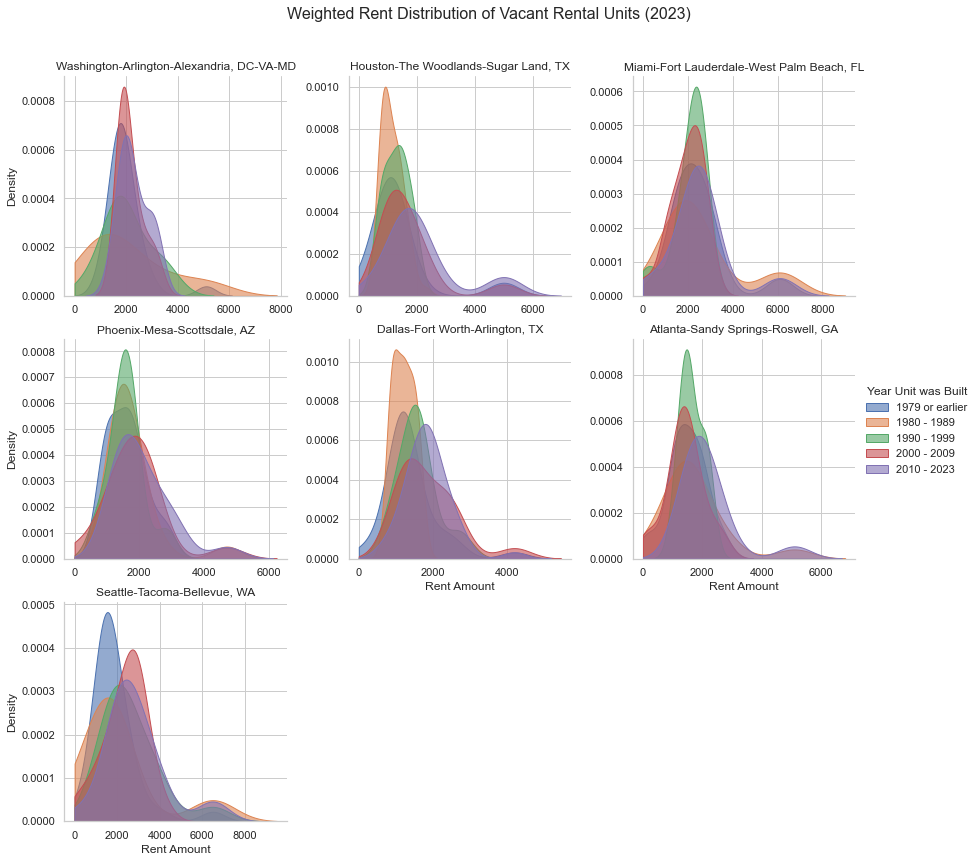

In [164]:
#Create FacetGrid with hue='YRBUILT_BIN'
g = sns.FacetGrid(
    new_vac_stock_rent_df, 
    col='Metro', 
    col_wrap=3, 
    height=4, 
    sharex=False, 
    sharey=False, 
    hue='YRBUILT_BIN'
)

#Plot directly using vectorized hue groups
g.map_dataframe(
    sns.kdeplot,
    x='RENT',
    weights='WEIGHT',
    fill=True,
    common_norm=False,
    alpha=0.6,
    linewidth=1,
    clip=(0, None)
)

#Labeling
g.add_legend(title="Year Unit was Built")
g.set_axis_labels("Rent Amount", "Density")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Weighted Rent Distribution of Vacant Rental Units (2023)", fontsize=16)

#Save and export image as png file
#plt.savefig('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/Analysis Visualizations/units_vacant_rent.png', dpi=300, bbox_inches='tight')

plt.show()